# Abstract

This draft will focus onan approach which will start by first finding the brightness of a point in a frame - create a detected object through this and measure it's centroid. The program will them import 4 more frames, and utilize the centroid similar as a filter for determining RSOs. In the last version of the program we had correctly identified star streaks, but had issues with proper RSO identification. Draft 3 will focusing on iterating through the entire library of images, and exporting as a 

# Import Images

In [1]:
csv_num_lim=235;
import numpy as np
import copy as c
img_data=[]
label_data=[]
for i in range(0,csv_num_lim):
    img_filename=('D:/School/Grad School Summer 2021/Assignment3Git/SampleData/sample_data_undergrads/images/'+str(i)+'.csv')
    img_data.append(np.genfromtxt(img_filename,delimiter=',',dtype=None))
    label_filename=('D:/School/Grad School Summer 2021/Assignment3Git/SampleData/sample_data_undergrads/labels/'+str(i)+'.csv')
    label_data.append(np.genfromtxt(label_filename,delimiter=',',dtype=None))
img_data=np.array(img_data);
label_data=np.array(label_data);

# Detections

In [2]:
first_frame=c.copy(img_data[0][:][:])
second_frame=c.copy(img_data[1][:][:])

In [3]:

#plt.matshow(first_frame)

In [4]:
from statistics import mode

mode_first_frame=mode(first_frame.flatten())

This is the mode common value in our frame, so we will consider this our "floor". Let's create a binary frame to visualize want the program will 'see'

In [5]:
import numpy as np
bin_first_frame=np.zeros(np.shape(first_frame))
for i in range(0,np.shape(first_frame)[0]):
    for j in range(0,np.shape(first_frame)[1]):
        if first_frame[i,j]>mode_first_frame:
            bin_first_frame[i,j]=1

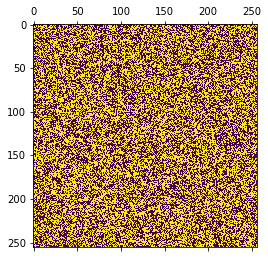

In [6]:
import matplotlib.pyplot as plt
plt.matshow(bin_first_frame)

This seems to be a little excessive. We should reduced the number of detection objects by increasing the threshold value

In [7]:
mean_first_frame=np.mean(first_frame)
import numpy as np
bin_first_frame=np.zeros(np.shape(first_frame))
for i in range(0,np.shape(first_frame)[0]):
    for j in range(0,np.shape(first_frame)[1]):
        if first_frame[i,j]>mean_first_frame:
            bin_first_frame[i,j]=1

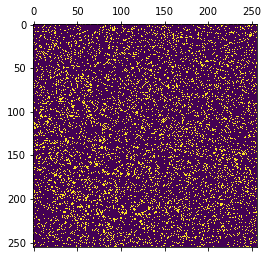

In [8]:
import matplotlib.pyplot as plt
plt.matshow(bin_first_frame)

These detections are still a bit high. Let's apply an abritrary number above the mean value to detect less--

In [9]:
mean_first_frame=np.mean(first_frame)+100
import numpy as np
bin_first_frame=np.zeros(np.shape(first_frame))
for i in range(0,np.shape(first_frame)[0]):
    for j in range(0,np.shape(first_frame)[1]):
        if first_frame[i,j]>mean_first_frame:
            bin_first_frame[i,j]=1

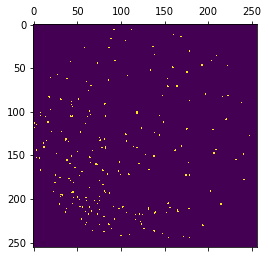

In [10]:
import matplotlib.pyplot as plt
plt.matshow(bin_first_frame)

This seems more appropriate. Comparing it to our labeled data

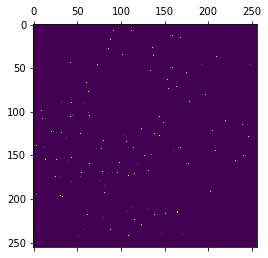

In [11]:
plt.matshow(label_data[1][:][:])

# Determining Clusters

In order to find the intrumental magnitude, we will need start by chosing a good aperature. To determine the apperature, we should first start by clustering the detections

In [12]:
#First create an array of all the coordinate of all the binary points
bin_first_frame_coords_1= np.where(bin_first_frame==1)
bin_first_frame_coords_2=[]
#Repackage Data
for i in range(0,np.shape(bin_first_frame_coords_1)[1]):
    bin_first_frame_coords_2.append([bin_first_frame_coords_1[0][i],bin_first_frame_coords_1[1][i]])

In [13]:
#We can then perform a Clustering Algorithm 
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=2,min_samples=1)
y_pred=db.fit_predict(bin_first_frame_coords_2)

## Visualizing Data

We want to visualize the clusters in order to see if they are accurately describing the situation

In [14]:
xdata=np.array(bin_first_frame_coords_2)[:,0]
ydata=np.array(bin_first_frame_coords_2)[:,1]
zdata=y_pred[:]
#zdata is the label number

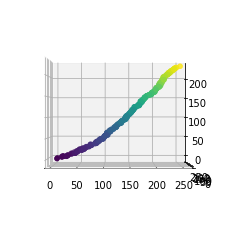

In [15]:
ax=plt.axes(projection='3d')
ax.scatter3D(xdata,ydata,zdata,c=zdata,cmap='viridis')
ax.view_init(0,-90)

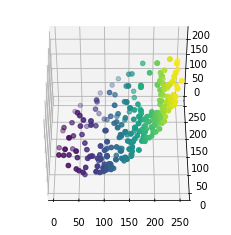

In [16]:
ax=plt.axes(projection='3d')
ax.scatter3D(xdata,ydata,zdata,c=zdata,cmap='viridis')
ax.view_init(45,-90)

In [17]:
 #Repackage Data into a 2D form
TwoD_clusterData=np.zeros(np.shape(bin_first_frame))    
cluster_data=[xdata,ydata,zdata]
for i in range(0,np.shape(cluster_data)[1]):
    TwoD_clusterData[xdata[i]][ydata[i]]=zdata[i]

In [18]:
np.shape(cluster_data)

(3, 492)

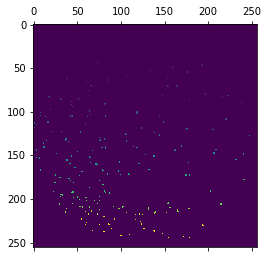

In [19]:
plt.matshow(TwoD_clusterData)

# Finding Centroids

Now that we have grouped together all the stars/RSO. Next step will be to find the centroid of the objects. We can find the centre by measuring all the bright pixels in the cluster  ( the detected pixels in binary image) and finding a new coordinate that fits into it

In [20]:
centroid_x=[]
#Linear Frame
centroid_y=[]
for i in range(0,np.max(zdata)):
    xcoords=xdata[np.where(zdata==i)]
    ycoords=ydata[np.where(zdata==i)]
    x_temp=np.zeros(np.shape(xcoords))
    y_temp=np.zeros(np.shape(ycoords))
    for j in range(0,np.shape(xcoords)[0]):
        x_temp[j]=(first_frame[xcoords,ycoords])[j]/np.sum(first_frame[xcoords,ycoords])*xcoords[j]
    for k in range(0,np.shape(ycoords)[0]):    
        y_temp[k]=(first_frame[xcoords,ycoords])[k]/np.sum(first_frame[xcoords,ycoords])*ycoords[k]
    centroid_x.append(np.sum(x_temp))
    centroid_y.append(np.sum(y_temp))  

#x,y,    

Centroids are now calculated for each cluster in the frame. 

# Scale

By scale, I think that we are assuming the approximate radius of each cluster

In [21]:
# cluster_data contains xcoords, ycoords, and group number. We can also add number of lit pixels to this

cluster_data_count=[]
#list of labels form

cluster_data_count2=[]
#x,y,z,
for i in range(np.min(zdata),np.max(zdata)):
    cluster_data_count.append(np.count_nonzero(i==zdata))
for k in range(0,np.shape(zdata)[0]):
    cluster_data_count2.append(np.count_nonzero(zdata[k]==zdata))
    

# Brightness

We've already used the brightness of a pixel when filtering into the binary image. We can use the average brightness of all the clusters and compare it to the next frame to see if we can find any matches 

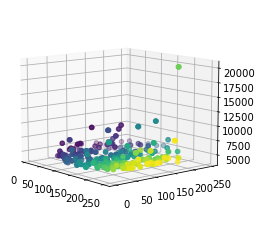

In [22]:
#This essentially finds the average of the pixels detected for a particular cluster
cluster_data_av_mag=[]
#2D form

cluster_data_av_mag_2=[]
#x,y,label form

for i in range(np.min(zdata),np.max(zdata)+1):
    cluster_data_av_mag.append(np.mean(first_frame[np.where(TwoD_clusterData==i)]))
for j in range(0,np.shape(cluster_data)[1]):
    cluster_data_av_mag_2.append(cluster_data_av_mag[(zdata[j])])
    
    
    
    
    
ax=plt.axes(projection='3d')
ax.scatter3D(xdata,ydata,cluster_data_av_mag_2,c=zdata,cmap='viridis')
ax.view_init(10,-40)
#Cluster Projection with Averaged Magntitude

# Motion Vectors

To find a motion vector we must have at least two points. So lets introduce a second frame and see if we can connect the first frame with the second frame

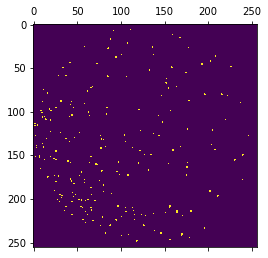

In [23]:
second_frame=img_data[1][:][:]
mean_second_frame=np.mean(second_frame)+100
import numpy as np
bin_second_frame=np.zeros(np.shape(second_frame))
for i in range(0,np.shape(second_frame)[0]):
    for j in range(0,np.shape(second_frame)[1]):
        if second_frame[i,j]>mean_second_frame:
            bin_second_frame[i,j]=1
plt.matshow(bin_second_frame)

Let's look at the difference between the two frames

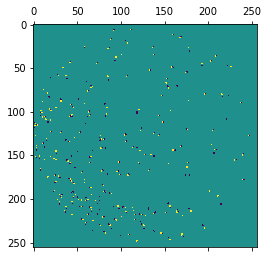

In [24]:
plt.matshow(bin_second_frame-bin_first_frame)

One method of finding the x and y vecolity vectors is by trying to make a connection between the clusters in the first frame and clusters in the second frame

## Clustering Second Frame

In [25]:
#First create an array of all the coordinate of all the binary points
bin_second_frame_coords_1= np.where(bin_second_frame==1)
bin_second_frame_coords_2=[]
#Repackage Data
for i in range(0,np.shape(bin_second_frame_coords_1)[1]):
    bin_second_frame_coords_2.append([bin_second_frame_coords_1[0][i],bin_second_frame_coords_1[1][i]])
#We can then perform a Clustering Algorithm 
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=2,min_samples=1)
y_pred=db.fit_predict(bin_second_frame_coords_2)

### Displaying Data

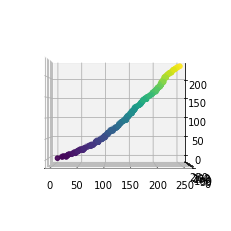

In [26]:
xdata2=np.array(bin_second_frame_coords_2)[:,0]
ydata2=np.array(bin_second_frame_coords_2)[:,1]
zdata2=y_pred[:]
ax=plt.axes(projection='3d')
ax.scatter3D(xdata2,ydata2,zdata2,c=zdata2,cmap='viridis')
ax.view_init(0,-90)

This figure shows that theres a good amount of seperation and that none of the clusters are considered outliers

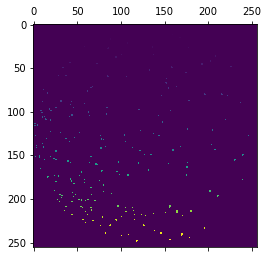

In [27]:
 #Repackage Data into a 2D form
TwoD_clusterData2=np.zeros(np.shape(bin_second_frame))    
cluster_data2=[xdata2,ydata2,zdata2]
for i in range(0,np.shape(cluster_data2)[1]):
    TwoD_clusterData2[xdata2[i]][ydata2[i]]=zdata2[i]
plt.matshow(TwoD_clusterData2)

In [28]:
np.shape(second_frame)

(256, 256)

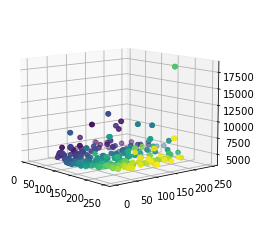

In [29]:
# cluster_data contains xcoords, ycoords, and group number. We can also add number of lit pixels to this
cluster_data_count_second_frame=[]

cluster_data_count_second_frame2=[]
for i in range(0,np.max(zdata2)):
    cluster_data_count_second_frame.append(np.count_nonzero(i==zdata2))
for k in range(0,np.shape(zdata2)[0]):
    cluster_data_count_second_frame2.append(np.count_nonzero(zdata2[k]==zdata2))
#This essentially finds the average of the pixels detected for a particular cluster


cluster_data_av_mag_second_frame=[]
#2D form

cluster_data_av_mag_2_second_frame=[]
#x,y,label form

for i in range(np.min(zdata2),np.max(zdata2)+1):
    cluster_data_av_mag_second_frame.append(np.mean(second_frame[np.where(TwoD_clusterData2==i)]))
for j in range(0,np.shape(zdata2)[0]):
    
    #xdata[np.where(zdata2[j]==zdata2)]
    
    cluster_data_av_mag_2_second_frame.append(cluster_data_av_mag_second_frame[(zdata2[j])])
   #Look into this 
  
    
ax=plt.axes(projection='3d')
ax.scatter3D(xdata2,ydata2,cluster_data_av_mag_2_second_frame,c=zdata2,cmap='viridis')
ax.view_init(10,-40)
#Cluster Projection with Averaged Magntitude

In [30]:
np.max(zdata2)

228

In [31]:
(zdata2[j])

228

In [32]:
np.shape(cluster_data_av_mag_second_frame)

(229,)

In [33]:
np.max(cluster_data_av_mag_2_second_frame)

18167.4

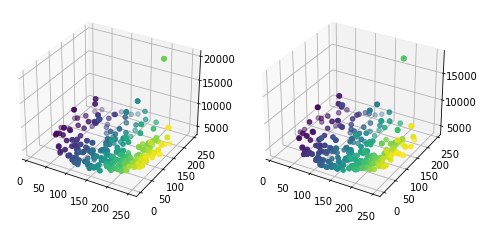

In [34]:
fig=plt.figure(figsize=plt.figaspect(0.5))
ax= fig.add_subplot(1,2,1,projection='3d')
ax.scatter3D(xdata,ydata,cluster_data_av_mag_2,c=zdata,cmap='viridis')

ax= fig.add_subplot(1,2,2,projection='3d')
ax.scatter3D(xdata2,ydata2,cluster_data_av_mag_2_second_frame,c=zdata2,cmap='viridis')


Comparing the first frame to the second we see that theres a big difference between the labels of Frame one's Clustering and frame two's Clustering. Specifically the maxmium brightness from the first frame is alot different than the second one. Let's try to find similarities with scale 

## Scale Matching

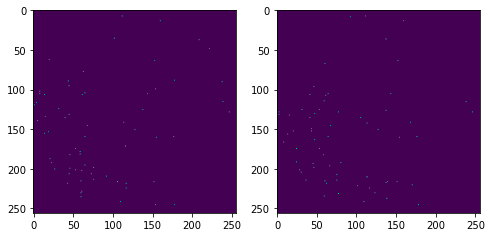

In [35]:
Group_of_1s=[xdata[np.transpose(cluster_data_count2[:])==1],ydata[np.transpose(cluster_data_count2[:])==1],np.array(cluster_data_av_mag_2)[np.transpose(cluster_data_count2[:])==1]]
Group_of_1s_second_frame=[xdata2[np.transpose(cluster_data_count_second_frame2[:])==1],ydata2[np.transpose(cluster_data_count_second_frame2[:])==1],np.array(cluster_data_av_mag_2_second_frame)[np.transpose(cluster_data_count_second_frame2[:])==1]] 

#finds the indexes of where the labels match the 
#np.where(zdata==((cluster_data_count2[:])==2))



_1sframe=np.zeros(np.shape(first_frame))    
reduced_xdata=Group_of_1s[0][:]
reduced_ydata=Group_of_1s[1][:]
reduced_bightness=Group_of_1s[2][:]
for i in range(0,np.shape(reduced_xdata)[0]):
            _1sframe[reduced_xdata[i]][reduced_ydata[i]]=reduced_bightness[i]
_1sframe2=np.zeros(np.shape(second_frame)) 
reduced_xdata2=Group_of_1s_second_frame[0][:]
reduced_ydata2=Group_of_1s_second_frame[1][:]
reduced_bightness2=Group_of_1s_second_frame[2][:]
for i in range(0,np.shape(reduced_xdata2)[0]):
            _1sframe2[reduced_xdata2[i]][reduced_ydata2[i]]=reduced_bightness2[i]
fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(_1sframe)
fig.add_subplot(1,2,2)
plt.imshow(_1sframe2)

These images display the the brightness of the pixels when the cluster size is equal to one. 

## Connecting Two Frames

We will attempt to connect the two frames by assuming that like points have similar brightness and average magnitude

In [36]:
possible_frame2_coords=[]
#frame1_x,frame1_y,[frame2_x,frame2_y]
reduced_possible_frame2_coords=[]

for i in range(0,np.shape(_1sframe)[0]):
    for j in range (0,np.shape(_1sframe)[1]):
        
        #If dot detected, perform search for second dot
        if _1sframe[i,j] != 0:
            #Perfrom "Search" based on average brightness
            possible_frame2_coords.append([i,j,np.where((_1sframe2>_1sframe[i,j]-15) & (_1sframe2<_1sframe[i,j]+15))])

#Filter with distance 
for i in range(0,np.shape(possible_frame2_coords)[0]):
    for j in range(0,np.shape(possible_frame2_coords[i][2])[1]):
        x_diff=possible_frame2_coords[i][0]-(possible_frame2_coords[i][2])[0][j]
        y_diff=possible_frame2_coords[i][1]-(possible_frame2_coords[i][2])[1][j]
        if ((np.linalg.norm(x_diff)<3) & (np.linalg.norm(y_diff)<3)):
            reduced_possible_frame2_coords.append([possible_frame2_coords[i][0],possible_frame2_coords[i][1],(possible_frame2_coords[i][2])[0][j],(possible_frame2_coords[i][2])[1][j]])


D:\Programs\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


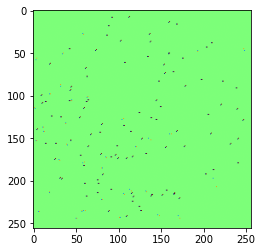

In [37]:
label_composite_img=label_data[0][:][:]-label_data[1][:][:]
cmap=plt.cm.jet #Adds Color Map
norm=plt.Normalize(vmin=label_composite_img.min(),vmax=label_composite_img.max()) #Normalizes Data
image4=cmap(norm(label_composite_img))
plt.imsave('Draft2_Label_composite.png',image4)
plt.imshow(image4)





## Draw Lines to connect the two frame


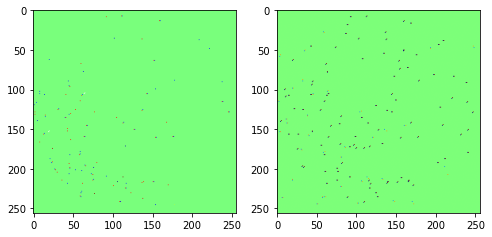

In [38]:
import cv2 as cv
compositeimg=_1sframe-_1sframe2
cmap=plt.cm.jet #Adds Color Map
norm=plt.Normalize(vmin=compositeimg.min(),vmax=compositeimg.max()) #Normalizes Data
image3=cmap(norm(compositeimg))
plt.imsave('Draft2_pic1.png',image3)
Draft2_pic1=cv.imread('Draft2_pic1.png')


for j in range(0,np.shape(reduced_possible_frame2_coords)[0]):
    cv.line(Draft2_pic1,(reduced_possible_frame2_coords[j][1],reduced_possible_frame2_coords[j][0]),(reduced_possible_frame2_coords[j][3],reduced_possible_frame2_coords[j][2]),(255,255,255),1)
fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic1)

fig.add_subplot(1,2,2)
plt.imshow(image4)
plt.rcParams["figure.figsize"]=(100,7)


# Iterate through Scale Matching for Two Frames

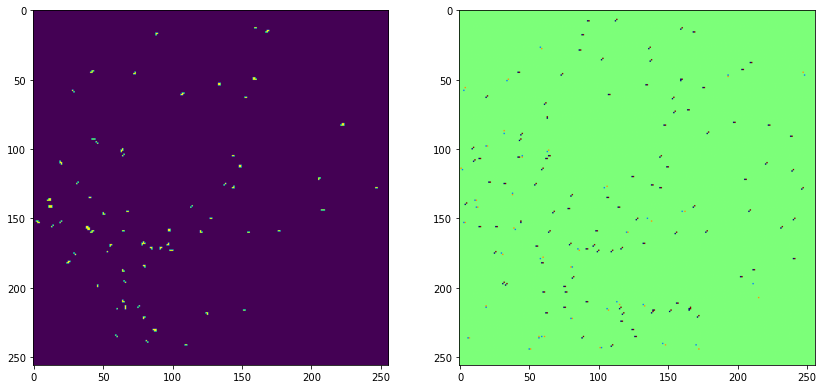

In [39]:
distance_calibration_matrix=[0.03,0.03,0.03,0.03,0.03,0.03,0.03]
#Calibration matrixes apply a set of distance, and magntitude paramters depenidng on cluster size. 
vector_diff_calibration_matrix=[2,2,2,2,2,2,3]

Draft2_pic1=np.zeros(np.shape(first_frame))
for m in range(1,np.max(cluster_data_count2)):
    
    Group_of_1s=[xdata[np.transpose(cluster_data_count2[:])==m],ydata[np.transpose(cluster_data_count2[:])==m],np.array(cluster_data_av_mag_2)[np.transpose(cluster_data_count2[:])==m]]
    Group_of_1s_second_frame=[xdata2[np.transpose(cluster_data_count_second_frame2[:])==m],ydata2[np.transpose(cluster_data_count_second_frame2[:])==m],np.array(cluster_data_av_mag_2_second_frame)[np.transpose(cluster_data_count_second_frame2[:])==m]] 

#finds the indexes of where the labels match the 
#np.where(zdata==((cluster_data_count2[:])==2))



    _1sframe=np.zeros(np.shape(first_frame))    
    reduced_xdata=Group_of_1s[0][:]
    reduced_ydata=Group_of_1s[1][:]
    reduced_bightness=Group_of_1s[2][:]
    for i in range(0,np.shape(reduced_xdata)[0]):
                _1sframe[reduced_xdata[i]][reduced_ydata[i]]=reduced_bightness[i]
    _1sframe2=np.zeros(np.shape(second_frame)) 
    reduced_xdata2=Group_of_1s_second_frame[0][:]
    reduced_ydata2=Group_of_1s_second_frame[1][:]
    reduced_bightness2=Group_of_1s_second_frame[2][:]
    for i in range(0,np.shape(reduced_xdata2)[0]):
                _1sframe2[reduced_xdata2[i]][reduced_ydata2[i]]=reduced_bightness2[i]
    

    possible_frame2_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame2_coords=[]

    for i in range(0,np.shape(_1sframe)[0]):
        for j in range (0,np.shape(_1sframe)[1]):

            #If dot detected, perform search for second dot
            if _1sframe[i,j] != 0:
                #Perfrom "Search" based on average brightness
                possible_frame2_coords.append([i,j,np.where((_1sframe2>(_1sframe[i,j]-(_1sframe[i,j]*distance_calibration_matrix[m]))) & (_1sframe2<(_1sframe[i,j]+(_1sframe[i,j]*distance_calibration_matrix[m]))))])

    #Filter with distance 
    for i in range(0,np.shape(possible_frame2_coords)[0]):
        for j in range(0,np.shape(possible_frame2_coords[i][2])[1]):
            x_diff=possible_frame2_coords[i][0]-(possible_frame2_coords[i][2])[0][j]
            y_diff=possible_frame2_coords[i][1]-(possible_frame2_coords[i][2])[1][j]
            if ((np.linalg.norm(x_diff)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff)<vector_diff_calibration_matrix[m])):
                reduced_possible_frame2_coords.append([possible_frame2_coords[i][0],possible_frame2_coords[i][1],(possible_frame2_coords[i][2])[0][j],(possible_frame2_coords[i][2])[1][j]])
    
    



    for j in range(0,np.shape(reduced_possible_frame2_coords)[0]):
        cv.line(Draft2_pic1,(reduced_possible_frame2_coords[j][3],reduced_possible_frame2_coords[j][2]),(reduced_possible_frame2_coords[j][1],reduced_possible_frame2_coords[j][0]),(255,255,255),1)
    


fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic1)

fig.add_subplot(1,2,2)
plt.imshow(image4)

    

# Add a 3rd Frame

In [41]:
third_frame=img_data[2][:][:]
mean_third_frame=np.mean(third_frame)+100
import numpy as np
bin_third_frame=np.zeros(np.shape(third_frame))
for i in range(0,np.shape(third_frame)[0]):
    for j in range(0,np.shape(third_frame)[1]):
        if third_frame[i,j]>mean_third_frame:
            bin_third_frame[i,j]=1
bin_third_frame_coords_1= np.where(bin_third_frame==1)
bin_third_frame_coords_2=[]
#Repackage Data
for i in range(0,np.shape(bin_third_frame_coords_1)[1]):
    bin_third_frame_coords_2.append([bin_third_frame_coords_1[0][i],bin_third_frame_coords_1[1][i]])
#We can then perform a Clustering Algorithm 
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=2,min_samples=1)
y_pred=db.fit_predict(bin_third_frame_coords_2)
xdata3=np.array(bin_third_frame_coords_2)[:,0]
ydata3=np.array(bin_third_frame_coords_2)[:,1]
zdata3=y_pred[:]
TwoD_clusterData3=np.zeros(np.shape(bin_third_frame))    
cluster_data3=[xdata3,ydata3,zdata3]
for i in range(0,np.shape(cluster_data3)[1]):
    TwoD_clusterData3[xdata3[i]][ydata3[i]]=zdata3[i]
# cluster_data contains xcoords, ycoords, and group number. We can also add number of lit pixels to this
cluster_data_count_third_frame=[]
cluster_data_count_third_frame2=[]
for i in range(0,np.max(zdata3)):
    cluster_data_count_third_frame.append(np.count_nonzero(i==zdata3))
for k in range(0,np.shape(zdata3)[0]):
    cluster_data_count_third_frame2.append(np.count_nonzero(zdata3[k]==zdata3))
#This essentially finds the average of the pixels detected for a particular cluster
cluster_data_av_mag_third_frame=[]
#2D form
cluster_data_av_mag_2_third_frame=[]
#x,y,label form
for i in range(np.min(zdata3),np.max(zdata3)+1):
    cluster_data_av_mag_third_frame.append(np.mean(third_frame[np.where(TwoD_clusterData3==i)]))
for j in range(0,np.shape(zdata3)[0]):
    cluster_data_av_mag_2_third_frame.append(cluster_data_av_mag_third_frame[(zdata3[j])])
   
   

In [42]:
np.shape(third_frame)

(256, 256)

In [43]:
np.shape(cluster_data_av_mag_third_frame)

(226,)

# Connect Third Frame

 First Let's find the difference in distance between frame 1 and frame 2 (xdiff and y diff) then lets find the distance between frame 2 and frame 3. If the distance is about the same, then we can say that those two points are connected. We can futher filter with slope. Most Stars will have similar from point 1 to point 2 and point 2 to point 3

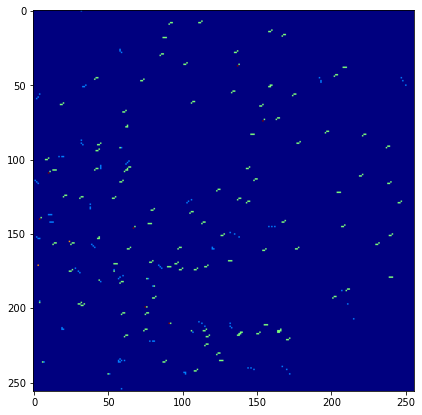

In [44]:
_3_layer_label_composite_img=label_data[0][:][:]+label_data[1][:][:]+label_data[2][:][:]
cmap=plt.cm.jet #Adds Color Map
norm=plt.Normalize(vmin=_3_layer_label_composite_img.min(),vmax=_3_layer_label_composite_img.max()) #Normalizes Data
image5=cmap(norm(_3_layer_label_composite_img))
plt.imsave('Draft2_Label_composite_3layer.png',image5)
plt.imshow(image5)

D:\Programs\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


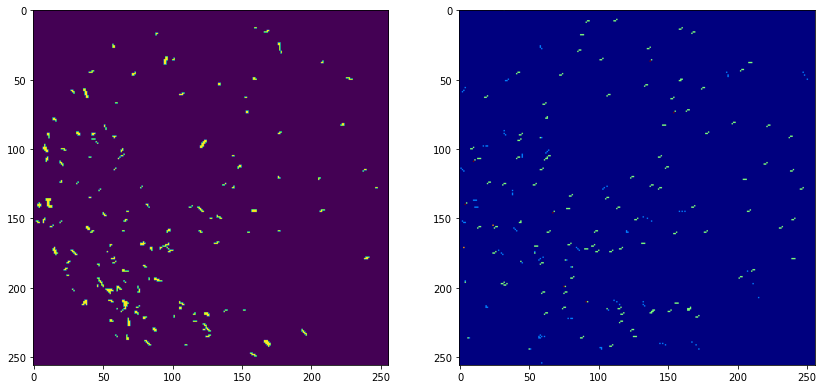

In [45]:

distance_calibration_matrix=[0.05,0.05,0.05,0.05,0.05,0.05,0.05]

#higher difference= more lines detected
vector_diff_calibration_matrix=[2,2,4,5,6,7,7]

Draft2_pic1=np.zeros(np.shape(first_frame))
for m in range(1,np.max(cluster_data_count2)):
    
    
    
    Group_of_1s=[xdata[np.transpose(cluster_data_count2[:])==m],ydata[np.transpose(cluster_data_count2[:])==m],np.array(cluster_data_av_mag_2)[np.transpose(cluster_data_count2[:])==m]]
    Group_of_1s_second_frame=[xdata2[np.transpose(cluster_data_count_second_frame2[:])==m],ydata2[np.transpose(cluster_data_count_second_frame2[:])==m],np.array(cluster_data_av_mag_2_second_frame)[np.transpose(cluster_data_count_second_frame2[:])==m]] 
    Group_of_1s_third_frame=[xdata3[np.transpose(cluster_data_count_third_frame2[:])==m],ydata3[np.transpose(cluster_data_count_third_frame2[:])==m],np.array(cluster_data_av_mag_2_third_frame)[np.transpose(cluster_data_count_third_frame2[:])==m]]
#finds the indexes of where the labels match the 
#np.where(zdata==((cluster_data_count2[:])==2))



    _1sframe=np.zeros(np.shape(first_frame))    
    reduced_xdata=Group_of_1s[0][:]
    reduced_ydata=Group_of_1s[1][:]
    reduced_bightness=Group_of_1s[2][:]
    for i in range(0,np.shape(reduced_xdata)[0]):
                _1sframe[reduced_xdata[i]][reduced_ydata[i]]=reduced_bightness[i]
    _1sframe2=np.zeros(np.shape(second_frame)) 
    reduced_xdata2=Group_of_1s_second_frame[0][:]
    reduced_ydata2=Group_of_1s_second_frame[1][:]
    reduced_bightness2=Group_of_1s_second_frame[2][:]
    for i in range(0,np.shape(reduced_xdata2)[0]):
                _1sframe2[reduced_xdata2[i]][reduced_ydata2[i]]=reduced_bightness2[i]
    _1sframe3=np.zeros(np.shape(third_frame)) 
    reduced_xdata3=Group_of_1s_third_frame[0][:]
    reduced_ydata3=Group_of_1s_third_frame[1][:]
    reduced_bightness3=Group_of_1s_third_frame[2][:]
    for i in range(0,np.shape(reduced_xdata3)[0]):
                _1sframe3[reduced_xdata3[i]][reduced_ydata3[i]]=reduced_bightness3[i]
    #possible frame 3 coordinates
    possible_frame3_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame3_coords=[]

    possible_frame2_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame2_coords=[]

    for i in range(0,np.shape(_1sframe)[0]):
        for j in range (0,np.shape(_1sframe)[1]):

            #If dot detected, perform search for second dot
            if _1sframe[i,j] != 0:
                #Perfrom "Search" based on average brightness
                possible_frame2_coords.append([i,j,np.where((_1sframe2>(_1sframe[i,j]-(_1sframe[i,j]*distance_calibration_matrix[m]))) & (_1sframe2<(_1sframe[i,j]+(_1sframe[i,j]*distance_calibration_matrix[m]))))])
    
    for i in range(0,np.shape(_1sframe2)[0]):
        for j in range(0,np.shape(_1sframe2)[1]):
            if _1sframe2[i,j] != 0:
                possible_frame3_coords.append([i,j,np.where((_1sframe3>(_1sframe2[i,j]-(_1sframe2[i,j]*distance_calibration_matrix[m]))) & (_1sframe3<(_1sframe2[i,j]+(_1sframe2[i,j]*distance_calibration_matrix[m]))))])
     
    
    #draw coords has frame1_x,frame1_y,frame2_x,frame2_y
    
    draw_coords=[]
    draw_coords2=[]
    #Filter with distance 
    for i in range(0,np.shape(possible_frame2_coords)[0]):
        for j in range(0,np.shape(possible_frame2_coords[i][2])[1]):
            x_diff=possible_frame2_coords[i][0]-(possible_frame2_coords[i][2])[0][j]
            y_diff=possible_frame2_coords[i][1]-(possible_frame2_coords[i][2])[1][j]
            if ((np.linalg.norm(x_diff)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff)<vector_diff_calibration_matrix[m])):
                draw_coords.append([possible_frame2_coords[i][0],possible_frame2_coords[i][1],(possible_frame2_coords[i][2])[0][j],(possible_frame2_coords[i][2])[1][j]])

    #draw_coords2 has frame2_x,frame2_y,frame3_x,frame3_y
    for k in range(0,np.shape(possible_frame3_coords)[0]):
        for l in range(0,np.shape(possible_frame3_coords[k][2])[1]):
            x_diff2=possible_frame3_coords[k][0]-(possible_frame3_coords[k][2])[0][l]
            y_diff2=possible_frame3_coords[k][1]-(possible_frame3_coords[k][2])[1][l]
            if ((np.linalg.norm(x_diff2)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff2)<vector_diff_calibration_matrix[m])):
                draw_coords2.append([possible_frame3_coords[k][0],possible_frame3_coords[k][1],(possible_frame3_coords[k][2])[0][l],(possible_frame3_coords[k][2])[1][l]])
    
    #Connections Filtering
    #Creates new lines from previous lines Frame 1 to 2, frame 2 to 3
    #draw_coords_3 has frame1_x,frame1_y,frame3_x,frame3_y
    draw_coords3=[]
    array_draw_coords=np.array(draw_coords)
    array_draw_coords2=np.array(draw_coords2)
    if (np.shape(draw_coords)[0]>0) & (np.shape(draw_coords2)[0]>0):
        for i in range(0,np.shape(array_draw_coords)[0]):
            for j in range(0,np.shape(array_draw_coords2)[0]):
                if ((array_draw_coords)[i,2]==array_draw_coords2[j,0]) & (array_draw_coords[i,3]==array_draw_coords2[j,1]) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 

    

    #Draw lines
    for i in range(0,np.shape(draw_coords2)[0]):
        cv.line(Draft2_pic1,(draw_coords2[i][3],draw_coords2[i][2]),(draw_coords2[i][1],draw_coords2[i][0]),(255,255,255),1)
    for i in range(0,np.shape(draw_coords)[0]):
        cv.line(Draft2_pic1,(draw_coords[i][3],draw_coords[i][2]),(draw_coords[i][1],draw_coords[i][0]),(255,255,255),1)
    
    


fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic1)

fig.add_subplot(1,2,2)
plt.imshow(image5)

 We need to apply some sort of filtering to clearly see the patterns that the frames are creating

## Continous Line Filtering

Essentially this filtering looks at the connections made between frame 1 and frame 2, frame 2 and frame 3 and sees if the coordinates on frame2 for both the sets of connections are the same. Only connections that have the same frame 2 cooridnates are allowed to be filtered through. into the "draw-coords3" parameter

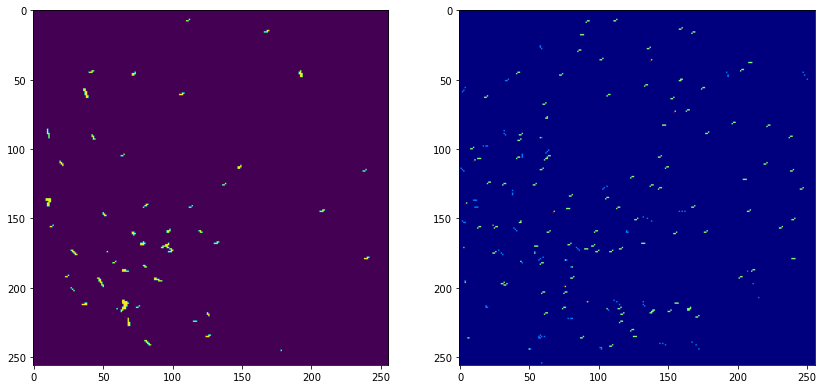

In [46]:

distance_calibration_matrix=[0.5,0.5,0.5,0.5,0.5,0.5,0.9]

#higher difference= more lines detected
vector_diff_calibration_matrix=[2,2,4,5,6,7,7]

Draft2_pic1=np.zeros(np.shape(first_frame))
for m in range(1,np.max(cluster_data_count2)):
    
    
    
    Group_of_1s=[xdata[np.transpose(cluster_data_count2[:])==m],ydata[np.transpose(cluster_data_count2[:])==m],np.array(cluster_data_av_mag_2)[np.transpose(cluster_data_count2[:])==m]]
    Group_of_1s_second_frame=[xdata2[np.transpose(cluster_data_count_second_frame2[:])==m],ydata2[np.transpose(cluster_data_count_second_frame2[:])==m],np.array(cluster_data_av_mag_2_second_frame)[np.transpose(cluster_data_count_second_frame2[:])==m]] 
    Group_of_1s_third_frame=[xdata3[np.transpose(cluster_data_count_third_frame2[:])==m],ydata3[np.transpose(cluster_data_count_third_frame2[:])==m],np.array(cluster_data_av_mag_2_third_frame)[np.transpose(cluster_data_count_third_frame2[:])==m]]
#finds the indexes of where the labels match the 
#np.where(zdata==((cluster_data_count2[:])==2))



    _1sframe=np.zeros(np.shape(first_frame))    
    reduced_xdata=Group_of_1s[0][:]
    reduced_ydata=Group_of_1s[1][:]
    reduced_bightness=Group_of_1s[2][:]
    for i in range(0,np.shape(reduced_xdata)[0]):
                _1sframe[reduced_xdata[i]][reduced_ydata[i]]=reduced_bightness[i]
    _1sframe2=np.zeros(np.shape(second_frame)) 
    reduced_xdata2=Group_of_1s_second_frame[0][:]
    reduced_ydata2=Group_of_1s_second_frame[1][:]
    reduced_bightness2=Group_of_1s_second_frame[2][:]
    for i in range(0,np.shape(reduced_xdata2)[0]):
                _1sframe2[reduced_xdata2[i]][reduced_ydata2[i]]=reduced_bightness2[i]
    _1sframe3=np.zeros(np.shape(third_frame)) 
    reduced_xdata3=Group_of_1s_third_frame[0][:]
    reduced_ydata3=Group_of_1s_third_frame[1][:]
    reduced_bightness3=Group_of_1s_third_frame[2][:]
    for i in range(0,np.shape(reduced_xdata3)[0]):
                _1sframe3[reduced_xdata3[i]][reduced_ydata3[i]]=reduced_bightness3[i]
    #possible frame 3 coordinates
    possible_frame3_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame3_coords=[]

    possible_frame2_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame2_coords=[]

    for i in range(0,np.shape(_1sframe)[0]):
        for j in range (0,np.shape(_1sframe)[1]):

            #If dot detected, perform search for second dot
            if _1sframe[i,j] != 0:
                #Perfrom "Search" based on average brightness
                possible_frame2_coords.append([i,j,np.where((_1sframe2>(_1sframe[i,j]-(_1sframe[i,j]*distance_calibration_matrix[m]))) & (_1sframe2<(_1sframe[i,j]+(_1sframe[i,j]*distance_calibration_matrix[m]))))])
    
    for i in range(0,np.shape(_1sframe2)[0]):
        for j in range(0,np.shape(_1sframe2)[1]):
            if _1sframe2[i,j] != 0:
                possible_frame3_coords.append([i,j,np.where((_1sframe3>(_1sframe2[i,j]-(_1sframe2[i,j]*distance_calibration_matrix[m]))) & (_1sframe3<(_1sframe2[i,j]+(_1sframe2[i,j]*distance_calibration_matrix[m]))))])
     
    
    #draw coords has frame1_x,frame1_y,frame2_x,frame2_y
    
    draw_coords=[]
    draw_coords2=[]
    #Filter with distance 
    for i in range(0,np.shape(possible_frame2_coords)[0]):
        for j in range(0,np.shape(possible_frame2_coords[i][2])[1]):
            x_diff=possible_frame2_coords[i][0]-(possible_frame2_coords[i][2])[0][j]
            y_diff=possible_frame2_coords[i][1]-(possible_frame2_coords[i][2])[1][j]
            if ((np.linalg.norm(x_diff)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff)<vector_diff_calibration_matrix[m])):
                draw_coords.append([possible_frame2_coords[i][0],possible_frame2_coords[i][1],(possible_frame2_coords[i][2])[0][j],(possible_frame2_coords[i][2])[1][j]])

    #draw_coords2 has frame2_x,frame2_y,frame3_x,frame3_y
    for k in range(0,np.shape(possible_frame3_coords)[0]):
        for l in range(0,np.shape(possible_frame3_coords[k][2])[1]):
            x_diff2=possible_frame3_coords[k][0]-(possible_frame3_coords[k][2])[0][l]
            y_diff2=possible_frame3_coords[k][1]-(possible_frame3_coords[k][2])[1][l]
            if ((np.linalg.norm(x_diff2)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff2)<vector_diff_calibration_matrix[m])):
                draw_coords2.append([possible_frame3_coords[k][0],possible_frame3_coords[k][1],(possible_frame3_coords[k][2])[0][l],(possible_frame3_coords[k][2])[1][l]])
    
    #Connections Filtering
    #Creates new lines from previous lines Frame 1 to 2, frame 2 to 3
    #draw_coords_3 has frame1_x,frame1_y,frame3_x,frame3_y
    draw_coords3=[]
    array_draw_coords=np.array(draw_coords)
    array_draw_coords2=np.array(draw_coords2)
    if (np.shape(draw_coords)[0]>0) & (np.shape(draw_coords2)[0]>0):
        for i in range(0,np.shape(array_draw_coords)[0]):
            for j in range(0,np.shape(array_draw_coords2)[0]):
                if (((array_draw_coords)[i,2]==array_draw_coords2[j,0]) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 

    

    #Draw lines
    for i in range(0,np.shape(draw_coords3)[0]):
        cv.line(Draft2_pic1,(draw_coords3[i][3],draw_coords3[i][2]),(draw_coords3[i][1],draw_coords3[i][0]),(255,255,255),1)

    
    


fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic1)

fig.add_subplot(1,2,2)
plt.imshow(image5)

This shows some promise. We could add a degree of error to our "connections"

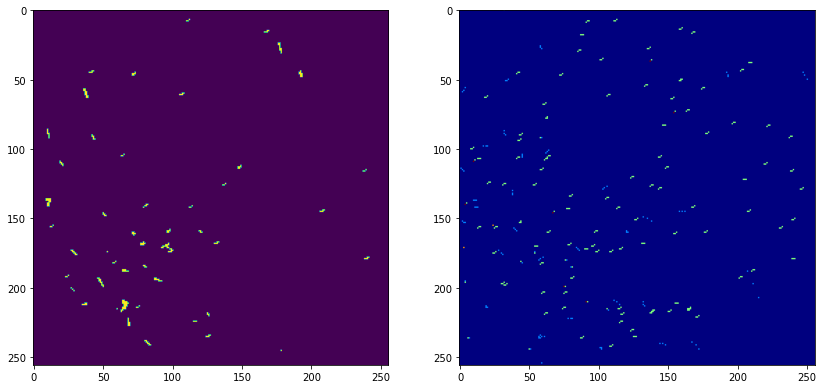

In [47]:

distance_calibration_matrix=[0.5,0.5,0.5,0.5,0.5,0.5,0.9]

#higher difference= more lines detected
vector_diff_calibration_matrix=[2,2,4,5,6,7,7]

Draft2_pic2=np.zeros(np.shape(first_frame))
for m in range(1,np.max(cluster_data_count2)):
    
    
    Group_of_1s=[xdata[np.transpose(cluster_data_count2[:])==m],ydata[np.transpose(cluster_data_count2[:])==m],np.array(cluster_data_av_mag_2)[np.transpose(cluster_data_count2[:])==m]]
    
    Group_of_1s_second_frame=[xdata2[np.transpose(cluster_data_count_second_frame2[:])==m],ydata2[np.transpose(cluster_data_count_second_frame2[:])==m],np.array(cluster_data_av_mag_2_second_frame)[np.transpose(cluster_data_count_second_frame2[:])==m]] 
    Group_of_1s_third_frame=[xdata3[np.transpose(cluster_data_count_third_frame2[:])==m],ydata3[np.transpose(cluster_data_count_third_frame2[:])==m],np.array(cluster_data_av_mag_2_third_frame)[np.transpose(cluster_data_count_third_frame2[:])==m]]
#finds the indexes of where the labels match the 
#np.where(zdata==((cluster_data_count2[:])==2))



    _1sframe=np.zeros(np.shape(first_frame))    
    reduced_xdata=Group_of_1s[0][:]
    reduced_ydata=Group_of_1s[1][:]
    reduced_bightness=Group_of_1s[2][:]
    for i in range(0,np.shape(reduced_xdata)[0]):
                _1sframe[reduced_xdata[i]][reduced_ydata[i]]=reduced_bightness[i]
    _1sframe2=np.zeros(np.shape(second_frame)) 
    reduced_xdata2=Group_of_1s_second_frame[0][:]
    reduced_ydata2=Group_of_1s_second_frame[1][:]
    reduced_bightness2=Group_of_1s_second_frame[2][:]
    for i in range(0,np.shape(reduced_xdata2)[0]):
                _1sframe2[reduced_xdata2[i]][reduced_ydata2[i]]=reduced_bightness2[i]
    _1sframe3=np.zeros(np.shape(third_frame)) 
    reduced_xdata3=Group_of_1s_third_frame[0][:]
    reduced_ydata3=Group_of_1s_third_frame[1][:]
    reduced_bightness3=Group_of_1s_third_frame[2][:]
    for i in range(0,np.shape(reduced_xdata3)[0]):
                _1sframe3[reduced_xdata3[i]][reduced_ydata3[i]]=reduced_bightness3[i]
    #possible frame 3 coordinates
    possible_frame3_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame3_coords=[]

    possible_frame2_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame2_coords=[]

    for i in range(0,np.shape(_1sframe)[0]):
        for j in range (0,np.shape(_1sframe)[1]):

            #If dot detected, perform search for second dot
            if _1sframe[i,j] != 0:
                #Perfrom "Search" based on average brightness
                possible_frame2_coords.append([i,j,np.where((_1sframe2>(_1sframe[i,j]-(_1sframe[i,j]*distance_calibration_matrix[m]))) & (_1sframe2<(_1sframe[i,j]+(_1sframe[i,j]*distance_calibration_matrix[m]))))])
    
    for i in range(0,np.shape(_1sframe2)[0]):
        for j in range(0,np.shape(_1sframe2)[1]):
            if _1sframe2[i,j] != 0:
                possible_frame3_coords.append([i,j,np.where((_1sframe3>(_1sframe2[i,j]-(_1sframe2[i,j]*distance_calibration_matrix[m]))) & (_1sframe3<(_1sframe2[i,j]+(_1sframe2[i,j]*distance_calibration_matrix[m]))))])
     
    
    #draw coords has frame1_x,frame1_y,frame2_x,frame2_y
    
    draw_coords=[]
    draw_coords2=[]
    #Filter with distance 
    for i in range(0,np.shape(possible_frame2_coords)[0]):
        for j in range(0,np.shape(possible_frame2_coords[i][2])[1]):
            x_diff=possible_frame2_coords[i][0]-(possible_frame2_coords[i][2])[0][j]
            y_diff=possible_frame2_coords[i][1]-(possible_frame2_coords[i][2])[1][j]
            if ((np.linalg.norm(x_diff)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff)<vector_diff_calibration_matrix[m])):
                draw_coords.append([possible_frame2_coords[i][0],possible_frame2_coords[i][1],(possible_frame2_coords[i][2])[0][j],(possible_frame2_coords[i][2])[1][j]])

    #draw_coords2 has frame2_x,frame2_y,frame3_x,frame3_y
    for k in range(0,np.shape(possible_frame3_coords)[0]):
        for l in range(0,np.shape(possible_frame3_coords[k][2])[1]):
            x_diff2=possible_frame3_coords[k][0]-(possible_frame3_coords[k][2])[0][l]
            y_diff2=possible_frame3_coords[k][1]-(possible_frame3_coords[k][2])[1][l]
            if ((np.linalg.norm(x_diff2)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff2)<vector_diff_calibration_matrix[m])):
                draw_coords2.append([possible_frame3_coords[k][0],possible_frame3_coords[k][1],(possible_frame3_coords[k][2])[0][l],(possible_frame3_coords[k][2])[1][l]])
    
    #Connections Filtering
    #Creates new lines from previous lines Frame 1 to 2, frame 2 to 3
    #draw_coords_3 has frame1_x,frame1_y,frame3_x,frame3_y
    draw_coords3=[]
    array_draw_coords=np.array(draw_coords)
    array_draw_coords2=np.array(draw_coords2)
    if (np.shape(draw_coords)[0]>0) & (np.shape(draw_coords2)[0]>0):
        for i in range(0,np.shape(array_draw_coords)[0]):
            for j in range(0,np.shape(array_draw_coords2)[0]):
                if (((array_draw_coords)[i,2]==array_draw_coords2[j,0]) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])+1) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])-1) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])) & (array_draw_coords[i,3]==array_draw_coords2[j,1]+1)) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])) & (array_draw_coords[i,3]==array_draw_coords2[j,1]-1)) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 

    

    #Draw lines
    for i in range(0,np.shape(draw_coords3)[0]):
        cv.line(Draft2_pic2,(draw_coords3[i][3],draw_coords3[i][2]),(draw_coords3[i][1],draw_coords3[i][0]),(255,255,255),1)

    
    


fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic2)

fig.add_subplot(1,2,2)
plt.imshow(image5)

Even when adding an error of +/-1 for the detection connections, we still fail to get a good reading. Aftering looking at the 5 frame binary image from  the previous draft we can furhter look at the number of pixels detected in a cluster

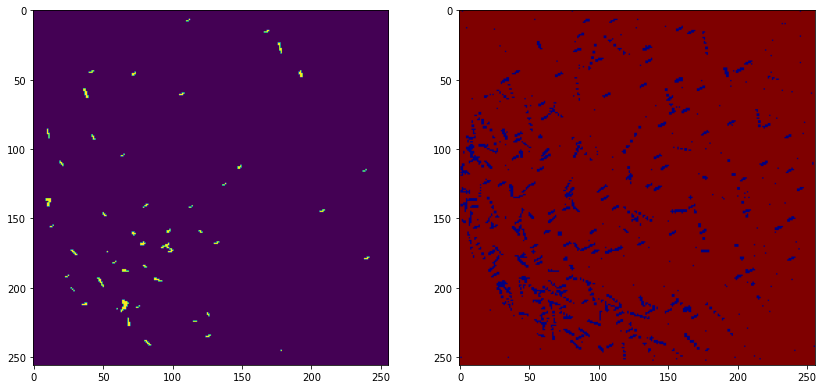

In [48]:
_5_frame_binary_Image=cv.imread("binaryimage.png")
#plt.matshow(_5_frame_binary_Image)

fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic2)

fig.add_subplot(1,2,2)
plt.imshow(_5_frame_binary_Image)

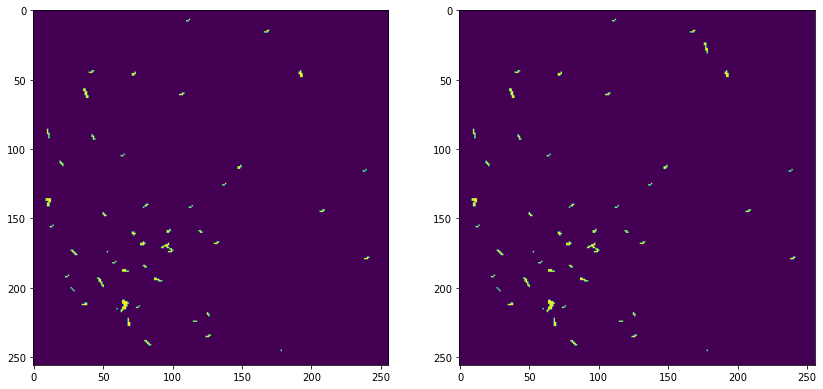

In [49]:
fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic1)

fig.add_subplot(1,2,2)
plt.imshow(Draft2_pic2)

We see that, even for larger objects the the cluster isn't confined to a certain number. Therefore we should edit the code so that it lets add an error to it

# Filtering by Averaged Magnitude

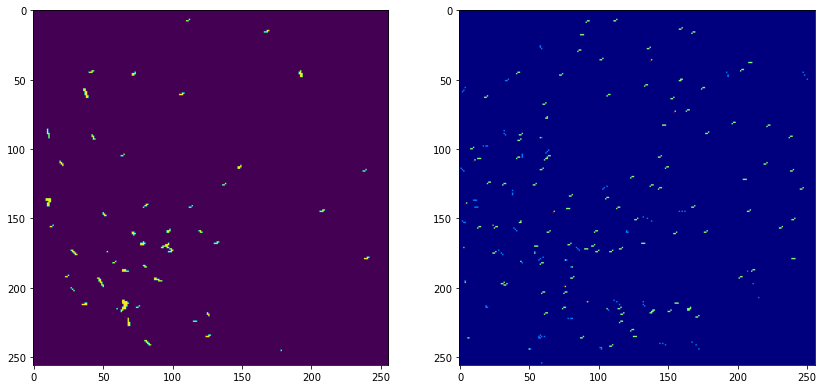

In [50]:
#distance_calibration_matrix=[0.3,0.3,0.3,0.3,0.3,0.3,0.9]

#higher difference= more lines detected
#vector_diff_calibration_matrix=[2,2,4,5,6,7,7]

Draft2_pic3=np.zeros(np.shape(first_frame))
for m in range(int(np.min(cluster_data_av_mag_2)),int(np.max(cluster_data_av_mag_2)),500):
    upper_lim=m+1000
    lower_lim=m-1000
    indx1=(np.transpose(cluster_data_av_mag_2[:])>lower_lim) & (np.transpose(cluster_data_av_mag_2[:])<upper_lim)
    indx2=(np.transpose(cluster_data_av_mag_2_second_frame[:])>lower_lim) & (np.transpose(cluster_data_av_mag_2_second_frame[:])<upper_lim)
    indx3=(np.transpose(cluster_data_av_mag_2_third_frame[:])>lower_lim) & (np.transpose(cluster_data_av_mag_2_third_frame[:])<upper_lim)
    Group_of_1s=[zdata[indx1],ydata[indx1],np.array(cluster_data_av_mag_2)[indx1]]
    Group_of_1s_second_frame=[xdata2[indx2],ydata2[indx2],np.array(cluster_data_av_mag_2_second_frame)[indx2]] 
    Group_of_1s_third_frame=[xdata3[indx3],ydata3[indx3],np.array(cluster_data_av_mag_2_third_frame)[indx3]]#finds the indexes of where the labels match the 
#np.where(zdata==((cluster_data_count2[:])==2))



    _1sframe=np.zeros(np.shape(first_frame))    
    reduced_xdata=Group_of_1s[0][:]
    reduced_ydata=Group_of_1s[1][:]
    reduced_bightness=Group_of_1s[2][:]
    for i in range(0,np.shape(reduced_xdata)[0]):
                _1sframe[reduced_xdata[i]][reduced_ydata[i]]=reduced_bightness[i]
    _1sframe2=np.zeros(np.shape(second_frame)) 
    reduced_xdata2=Group_of_1s_second_frame[0][:]
    reduced_ydata2=Group_of_1s_second_frame[1][:]
    reduced_bightness2=Group_of_1s_second_frame[2][:]
    for i in range(0,np.shape(reduced_xdata2)[0]):
                _1sframe2[reduced_xdata2[i]][reduced_ydata2[i]]=reduced_bightness2[i]
    _1sframe3=np.zeros(np.shape(third_frame)) 
    reduced_xdata3=Group_of_1s_third_frame[0][:]
    reduced_ydata3=Group_of_1s_third_frame[1][:]
    reduced_bightness3=Group_of_1s_third_frame[2][:]
    for i in range(0,np.shape(reduced_xdata3)[0]):
                _1sframe3[reduced_xdata3[i]][reduced_ydata3[i]]=reduced_bightness3[i]
    #possible frame 3 coordinates
    possible_frame3_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame3_coords=[]

    possible_frame2_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame2_coords=[]

    for i in range(0,np.shape(_1sframe)[0]):
        for j in range (0,np.shape(_1sframe)[1]):

            #If dot detected, perform search for second dot
            if _1sframe[i,j] != 0:
                #Perfrom "Search" based on average brightness
                possible_frame2_coords.append([i,j,np.where((_1sframe2>(_1sframe[i,j]-(_1sframe[i,j]*0.5))) & (_1sframe2<(_1sframe[i,j]+(_1sframe[i,j]*0.5))))])
    
    for i in range(0,np.shape(_1sframe2)[0]):
        for j in range(0,np.shape(_1sframe2)[1]):
            if _1sframe2[i,j] != 0:
                possible_frame3_coords.append([i,j,np.where((_1sframe3>(_1sframe2[i,j]-(_1sframe2[i,j]*0.5))) & (_1sframe3<(_1sframe2[i,j]+(_1sframe2[i,j]*0.5))))])
     
    
    #draw coords has frame1_x,frame1_y,frame2_x,frame2_y
    
    draw_coords=[]
    draw_coords2=[]
    #Filter with distance 
    for i in range(0,np.shape(possible_frame2_coords)[0]):
        for j in range(0,np.shape(possible_frame2_coords[i][2])[1]):
            x_diff=possible_frame2_coords[i][0]-(possible_frame2_coords[i][2])[0][j]
            y_diff=possible_frame2_coords[i][1]-(possible_frame2_coords[i][2])[1][j]
            if ((np.linalg.norm(x_diff)<3) & (np.linalg.norm(y_diff)<3)):
                draw_coords.append([possible_frame2_coords[i][0],possible_frame2_coords[i][1],(possible_frame2_coords[i][2])[0][j],(possible_frame2_coords[i][2])[1][j]])

    #draw_coords2 has frame2_x,frame2_y,frame3_x,frame3_y
    for k in range(0,np.shape(possible_frame3_coords)[0]):
        for l in range(0,np.shape(possible_frame3_coords[k][2])[1]):
            x_diff2=possible_frame3_coords[k][0]-(possible_frame3_coords[k][2])[0][l]
            y_diff2=possible_frame3_coords[k][1]-(possible_frame3_coords[k][2])[1][l]
            if ((np.linalg.norm(x_diff2)<3) & (np.linalg.norm(y_diff2)<3)):
                draw_coords2.append([possible_frame3_coords[k][0],possible_frame3_coords[k][1],(possible_frame3_coords[k][2])[0][l],(possible_frame3_coords[k][2])[1][l]])
    
    #Connections Filtering
    #Creates new lines from previous lines Frame 1 to 2, frame 2 to 3
    #draw_coords_3 has frame1_x,frame1_y,frame3_x,frame3_y
    draw_coords3=[]
    array_draw_coords=np.array(draw_coords)
    array_draw_coords2=np.array(draw_coords2)
    if (np.shape(draw_coords)[0]>0) & (np.shape(draw_coords2)[0]>0):
        for i in range(0,np.shape(array_draw_coords)[0]):
            for j in range(0,np.shape(array_draw_coords2)[0]):
                if (((array_draw_coords)[i,2]==array_draw_coords2[j,0]) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])+1) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])-1) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])) & (array_draw_coords[i,3]==array_draw_coords2[j,1]+1)) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])) & (array_draw_coords[i,3]==array_draw_coords2[j,1]-1)) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 

    

    #Draw lines
    for i in range(0,np.shape(draw_coords3)[0]):
        cv.line(Draft2_pic3,(draw_coords3[i][3],draw_coords3[i][2]),(draw_coords3[i][1],draw_coords3[i][0]),(255,255,255),1)
  
    


fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic1)

fig.add_subplot(1,2,2)
plt.imshow(image5) 

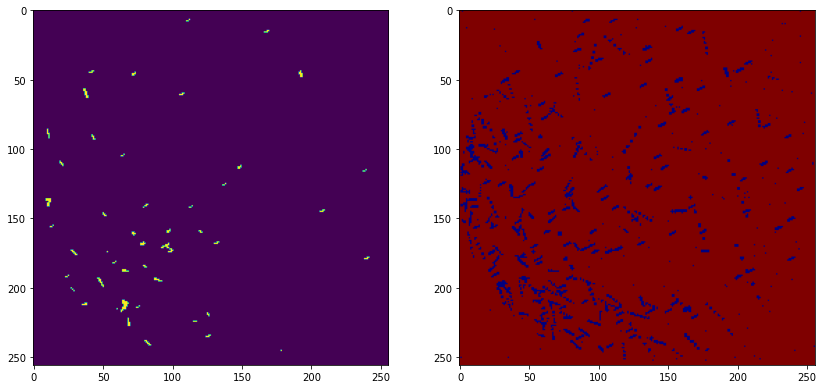

In [51]:
fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic1)

fig.add_subplot(1,2,2)
plt.imshow(_5_frame_binary_Image) 

The program still struggles to detect  RSO or stars. Let's take another look at the previous version of the program to see if we can use the information gathered there to determine RSOs (since we already calssified stars)

## Adding Error to Clsuter Size


Noting that exposure slicing isn't working too well when replacing our cluster size iteration. Let's try to add some error to our cluster size in the initalial "1frames"

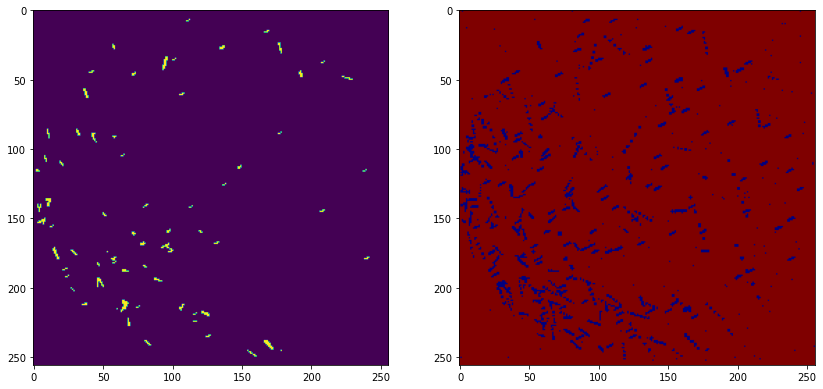

In [52]:

distance_calibration_matrix=[0.5,0.5,0.5,0.5,0.5,0.5,0.9]

#higher difference= more lines detected
vector_diff_calibration_matrix=[2,2,4,5,6,7,7]

Draft2_pic4=np.zeros(np.shape(first_frame))
for m in range(1,np.max(cluster_data_count2)):
    
    if ((m!=1) | (m!=np.max(cluster_data_count2))):
        
        Group_of_1s=[xdata[(np.transpose(cluster_data_count2[:])==m) | (np.transpose(cluster_data_count2[:])==(m-1))]\
                     ,ydata[(np.transpose(cluster_data_count2[:])==m) | (np.transpose(cluster_data_count2[:])==(m-1))]\
                     ,np.array(cluster_data_av_mag_2)\
                     [(np.transpose(cluster_data_count2[:])==m)  | (np.transpose(cluster_data_count2[:])==(m-1))]]    
        Group_of_1s_second_frame=[xdata2[np.transpose(cluster_data_count_second_frame2[:])==m],ydata2[np.transpose(cluster_data_count_second_frame2[:])==m],np.array(cluster_data_av_mag_2_second_frame)[np.transpose(cluster_data_count_second_frame2[:])==m]] 
        Group_of_1s_third_frame=[xdata3[np.transpose(cluster_data_count_third_frame2[:])==m],ydata3[np.transpose(cluster_data_count_third_frame2[:])==m],np.array(cluster_data_av_mag_2_third_frame)[np.transpose(cluster_data_count_third_frame2[:])==m]]
    else:
        Group_of_1s=[xdata[np.transpose(cluster_data_count2[:])==m],ydata[np.transpose(cluster_data_count2[:])==m],np.array(cluster_data_av_mag_2)[np.transpose(cluster_data_count2[:])==m]]
    
        Group_of_1s_second_frame=[xdata2[np.transpose(cluster_data_count_second_frame2[:])==m],ydata2[np.transpose(cluster_data_count_second_frame2[:])==m],np.array(cluster_data_av_mag_2_second_frame)[np.transpose(cluster_data_count_second_frame2[:])==m]] 
        Group_of_1s_third_frame=[xdata3[np.transpose(cluster_data_count_third_frame2[:])==m],ydata3[np.transpose(cluster_data_count_third_frame2[:])==m],np.array(cluster_data_av_mag_2_third_frame)[np.transpose(cluster_data_count_third_frame2[:])==m]]




    _1sframe=np.zeros(np.shape(first_frame))    
    reduced_xdata=Group_of_1s[0][:]
    reduced_ydata=Group_of_1s[1][:]
    reduced_bightness=Group_of_1s[2][:]
    for i in range(0,np.shape(reduced_xdata)[0]):
                _1sframe[reduced_xdata[i]][reduced_ydata[i]]=reduced_bightness[i]
    _1sframe2=np.zeros(np.shape(second_frame)) 
    reduced_xdata2=Group_of_1s_second_frame[0][:]
    reduced_ydata2=Group_of_1s_second_frame[1][:]
    reduced_bightness2=Group_of_1s_second_frame[2][:]
    for i in range(0,np.shape(reduced_xdata2)[0]):
                _1sframe2[reduced_xdata2[i]][reduced_ydata2[i]]=reduced_bightness2[i]
    _1sframe3=np.zeros(np.shape(third_frame)) 
    reduced_xdata3=Group_of_1s_third_frame[0][:]
    reduced_ydata3=Group_of_1s_third_frame[1][:]
    reduced_bightness3=Group_of_1s_third_frame[2][:]
    for i in range(0,np.shape(reduced_xdata3)[0]):
                _1sframe3[reduced_xdata3[i]][reduced_ydata3[i]]=reduced_bightness3[i]
    #possible frame 3 coordinates
    possible_frame3_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame3_coords=[]

    possible_frame2_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame2_coords=[]

    for i in range(0,np.shape(_1sframe)[0]):
        for j in range (0,np.shape(_1sframe)[1]):

            #If dot detected, perform search for second dot
            if _1sframe[i,j] != 0:
                #Perfrom "Search" based on average brightness
                possible_frame2_coords.append([i,j,np.where((_1sframe2>(_1sframe[i,j]-(_1sframe[i,j]*distance_calibration_matrix[m]))) & (_1sframe2<(_1sframe[i,j]+(_1sframe[i,j]*distance_calibration_matrix[m]))))])
    
    for i in range(0,np.shape(_1sframe2)[0]):
        for j in range(0,np.shape(_1sframe2)[1]):
            if _1sframe2[i,j] != 0:
                possible_frame3_coords.append([i,j,np.where((_1sframe3>(_1sframe2[i,j]-(_1sframe2[i,j]*distance_calibration_matrix[m]))) & (_1sframe3<(_1sframe2[i,j]+(_1sframe2[i,j]*distance_calibration_matrix[m]))))])
     
    
    #draw coords has frame1_x,frame1_y,frame2_x,frame2_y
    
    draw_coords=[]
    draw_coords2=[]
    #Filter with distance 
    for i in range(0,np.shape(possible_frame2_coords)[0]):
        for j in range(0,np.shape(possible_frame2_coords[i][2])[1]):
            x_diff=possible_frame2_coords[i][0]-(possible_frame2_coords[i][2])[0][j]
            y_diff=possible_frame2_coords[i][1]-(possible_frame2_coords[i][2])[1][j]
            if ((np.linalg.norm(x_diff)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff)<vector_diff_calibration_matrix[m])):
                draw_coords.append([possible_frame2_coords[i][0],possible_frame2_coords[i][1],(possible_frame2_coords[i][2])[0][j],(possible_frame2_coords[i][2])[1][j]])

    #draw_coords2 has frame2_x,frame2_y,frame3_x,frame3_y
    for k in range(0,np.shape(possible_frame3_coords)[0]):
        for l in range(0,np.shape(possible_frame3_coords[k][2])[1]):
            x_diff2=possible_frame3_coords[k][0]-(possible_frame3_coords[k][2])[0][l]
            y_diff2=possible_frame3_coords[k][1]-(possible_frame3_coords[k][2])[1][l]
            if ((np.linalg.norm(x_diff2)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff2)<vector_diff_calibration_matrix[m])):
                draw_coords2.append([possible_frame3_coords[k][0],possible_frame3_coords[k][1],(possible_frame3_coords[k][2])[0][l],(possible_frame3_coords[k][2])[1][l]])
    
    #Connections Filtering
    #Creates new lines from previous lines Frame 1 to 2, frame 2 to 3
    #draw_coords_3 has frame1_x,frame1_y,frame3_x,frame3_y
    draw_coords3=[]
    array_draw_coords=np.array(draw_coords)
    array_draw_coords2=np.array(draw_coords2)
    if (np.shape(draw_coords)[0]>0) & (np.shape(draw_coords2)[0]>0):
        for i in range(0,np.shape(array_draw_coords)[0]):
            for j in range(0,np.shape(array_draw_coords2)[0]):
                if (((array_draw_coords)[i,2]==array_draw_coords2[j,0]) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])+1) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])-1) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])) & (array_draw_coords[i,3]==array_draw_coords2[j,1]+1)) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])) & (array_draw_coords[i,3]==array_draw_coords2[j,1]-1)) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 

    

    #Draw lines
    for i in range(0,np.shape(draw_coords3)[0]):
        cv.line(Draft2_pic4,(draw_coords3[i][3],draw_coords3[i][2]),(draw_coords3[i][1],draw_coords3[i][0]),(255,255,255),1)

    
    


fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic4)

fig.add_subplot(1,2,2)
plt.imshow(_5_frame_binary_Image)

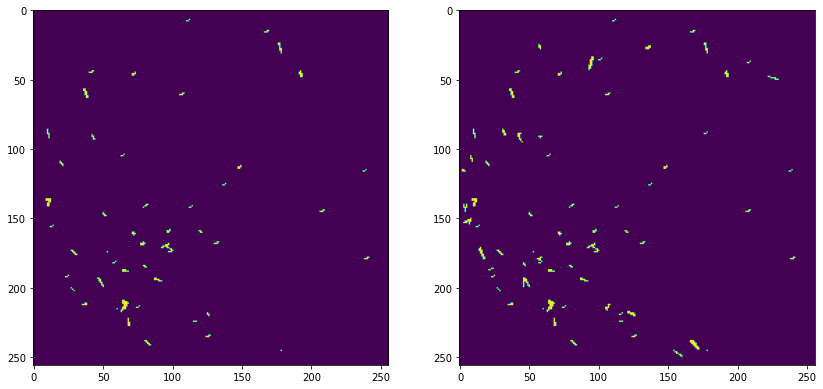

In [53]:
fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic2)

fig.add_subplot(1,2,2)
plt.imshow(Draft2_pic4)

These results are looking alot better. One thing to note however is that the slope lines being connected aren't always the same. This should be addressed in furhter studies. 

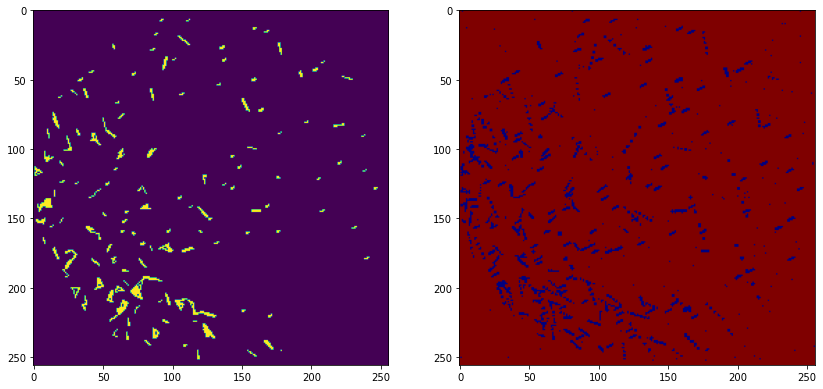

In [54]:

distance_calibration_matrix=[0.5,0.5,0.5,0.5,0.5,0.5,0.5]

#higher difference= more lines detected
vector_diff_calibration_matrix=[2,3,5,6,7,8,9]

Draft2_pic4=np.zeros(np.shape(first_frame))
for m in range(1,np.max(cluster_data_count2)):
    
    if ((m!=1) | (m!=np.max(cluster_data_count2))):
        cluster_indx1=(np.transpose(cluster_data_count2[:])==m) | (np.transpose(cluster_data_count2[:])==(m-1) | (np.transpose(cluster_data_count2[:])==(m+1)))
        cluster_indx2=(np.transpose(cluster_data_count_second_frame2[:])==m) | (np.transpose(cluster_data_count_second_frame2[:])==(m-1) | (np.transpose(cluster_data_count_second_frame2[:])==(m+1)))
        cluster_indx3=(np.transpose(cluster_data_count_third_frame2[:])==m) | (np.transpose(cluster_data_count_third_frame2[:])==(m-1) | (np.transpose(cluster_data_count_third_frame2[:])==(m+1)))
        
        Group_of_1s=[xdata[cluster_indx1],ydata[cluster_indx1],np.array(cluster_data_av_mag_2)[cluster_indx1]]    
        Group_of_1s_second_frame=[xdata2[cluster_indx2],ydata2[cluster_indx2],np.array(cluster_data_av_mag_2_second_frame)[cluster_indx2]] 
        Group_of_1s_third_frame=[xdata3[cluster_indx3],ydata3[cluster_indx3],np.array(cluster_data_av_mag_2_third_frame)[cluster_indx3]]
    else:
        Group_of_1s=[xdata[np.transpose(cluster_data_count2[:])==m],ydata[np.transpose(cluster_data_count2[:])==m],np.array(cluster_data_av_mag_2)[np.transpose(cluster_data_count2[:])==m]]
        Group_of_1s_second_frame=[xdata2[np.transpose(cluster_data_count_second_frame2[:])==m],ydata2[np.transpose(cluster_data_count_second_frame2[:])==m],np.array(cluster_data_av_mag_2_second_frame)[np.transpose(cluster_data_count_second_frame2[:])==m]] 
        Group_of_1s_third_frame=[xdata3[np.transpose(cluster_data_count_third_frame2[:])==m],ydata3[np.transpose(cluster_data_count_third_frame2[:])==m],np.array(cluster_data_av_mag_2_third_frame)[np.transpose(cluster_data_count_third_frame2[:])==m]]




    _1sframe=np.zeros(np.shape(first_frame))    
    reduced_xdata=Group_of_1s[0][:]
    reduced_ydata=Group_of_1s[1][:]
    reduced_bightness=Group_of_1s[2][:]
    for i in range(0,np.shape(reduced_xdata)[0]):
                _1sframe[reduced_xdata[i]][reduced_ydata[i]]=reduced_bightness[i]
    _1sframe2=np.zeros(np.shape(second_frame)) 
    reduced_xdata2=Group_of_1s_second_frame[0][:]
    reduced_ydata2=Group_of_1s_second_frame[1][:]
    reduced_bightness2=Group_of_1s_second_frame[2][:]
    for i in range(0,np.shape(reduced_xdata2)[0]):
                _1sframe2[reduced_xdata2[i]][reduced_ydata2[i]]=reduced_bightness2[i]
    _1sframe3=np.zeros(np.shape(third_frame)) 
    reduced_xdata3=Group_of_1s_third_frame[0][:]
    reduced_ydata3=Group_of_1s_third_frame[1][:]
    reduced_bightness3=Group_of_1s_third_frame[2][:]
    for i in range(0,np.shape(reduced_xdata3)[0]):
                _1sframe3[reduced_xdata3[i]][reduced_ydata3[i]]=reduced_bightness3[i]
    #possible frame 3 coordinates
    possible_frame3_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame3_coords=[]

    possible_frame2_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame2_coords=[]

    for i in range(0,np.shape(_1sframe)[0]):
        for j in range (0,np.shape(_1sframe)[1]):

            #If dot detected, perform search for second dot
            if _1sframe[i,j] != 0:
                #Perfrom "Search" based on average brightness
                possible_frame2_coords.append([i,j,np.where((_1sframe2>(_1sframe[i,j]-(_1sframe[i,j]*distance_calibration_matrix[m]))) & (_1sframe2<(_1sframe[i,j]+(_1sframe[i,j]*distance_calibration_matrix[m]))))])
    
    for i in range(0,np.shape(_1sframe2)[0]):
        for j in range(0,np.shape(_1sframe2)[1]):
            if _1sframe2[i,j] != 0:
                possible_frame3_coords.append([i,j,np.where((_1sframe3>(_1sframe2[i,j]-(_1sframe2[i,j]*distance_calibration_matrix[m]))) & (_1sframe3<(_1sframe2[i,j]+(_1sframe2[i,j]*distance_calibration_matrix[m]))))])
     
    
    #draw coords has frame1_x,frame1_y,frame2_x,frame2_y
    
    draw_coords=[]
    draw_coords2=[]
    #Filter with distance 
    for i in range(0,np.shape(possible_frame2_coords)[0]):
        for j in range(0,np.shape(possible_frame2_coords[i][2])[1]):
            x_diff=possible_frame2_coords[i][0]-(possible_frame2_coords[i][2])[0][j]
            y_diff=possible_frame2_coords[i][1]-(possible_frame2_coords[i][2])[1][j]
            if ((np.linalg.norm(x_diff)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff)<vector_diff_calibration_matrix[m])):
                draw_coords.append([possible_frame2_coords[i][0],possible_frame2_coords[i][1],(possible_frame2_coords[i][2])[0][j],(possible_frame2_coords[i][2])[1][j]])

    #draw_coords2 has frame2_x,frame2_y,frame3_x,frame3_y
    for k in range(0,np.shape(possible_frame3_coords)[0]):
        for l in range(0,np.shape(possible_frame3_coords[k][2])[1]):
            x_diff2=possible_frame3_coords[k][0]-(possible_frame3_coords[k][2])[0][l]
            y_diff2=possible_frame3_coords[k][1]-(possible_frame3_coords[k][2])[1][l]
            if ((np.linalg.norm(x_diff2)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff2)<vector_diff_calibration_matrix[m])):
                draw_coords2.append([possible_frame3_coords[k][0],possible_frame3_coords[k][1],(possible_frame3_coords[k][2])[0][l],(possible_frame3_coords[k][2])[1][l]])
    
    #Connections Filtering
    #Creates new lines from previous lines Frame 1 to 2, frame 2 to 3
    #draw_coords_3 has frame1_x,frame1_y,frame3_x,frame3_y
    draw_coords3=[]
    array_draw_coords=np.array(draw_coords)
    array_draw_coords2=np.array(draw_coords2)
    if (np.shape(draw_coords)[0]>0) & (np.shape(draw_coords2)[0]>0):
        for i in range(0,np.shape(array_draw_coords)[0]):
            for j in range(0,np.shape(array_draw_coords2)[0]):
                if (((array_draw_coords)[i,2]==array_draw_coords2[j,0]) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])+1) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])-1) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])) & (array_draw_coords[i,3]==array_draw_coords2[j,1]+1)) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])) & (array_draw_coords[i,3]==array_draw_coords2[j,1]-1)) :
                    draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 

    

    #Draw lines
    for i in range(0,np.shape(draw_coords3)[0]):
        cv.line(Draft2_pic4,(draw_coords3[i][3],draw_coords3[i][2]),(draw_coords3[i][1],draw_coords3[i][0]),(255,255,255),1)

    
    


fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic4)

fig.add_subplot(1,2,2)
plt.imshow(_5_frame_binary_Image)

More connections are being made. Lets limit the  connected lines so that they have the same/similar slopes

<ipython-input-119-b7bbb5c03a49>:107: RuntimeWarning: divide by zero encountered in longlong_scalars
  slope1=np.linalg.norm((array_draw_coords[i,3]-array_draw_coords[i,1])/(array_draw_coords[i,2]-array_draw_coords[i,0]))
<ipython-input-119-b7bbb5c03a49>:108: RuntimeWarning: divide by zero encountered in longlong_scalars
  slope2=np.linalg.norm((array_draw_coords2[j,3]-array_draw_coords2[j,1])/(array_draw_coords2[j,2]-array_draw_coords2[j,0]))
<ipython-input-119-b7bbb5c03a49>:108: RuntimeWarning: invalid value encountered in longlong_scalars
  slope2=np.linalg.norm((array_draw_coords2[j,3]-array_draw_coords2[j,1])/(array_draw_coords2[j,2]-array_draw_coords2[j,0]))
<ipython-input-119-b7bbb5c03a49>:107: RuntimeWarning: invalid value encountered in longlong_scalars
  slope1=np.linalg.norm((array_draw_coords[i,3]-array_draw_coords[i,1])/(array_draw_coords[i,2]-array_draw_coords[i,0]))


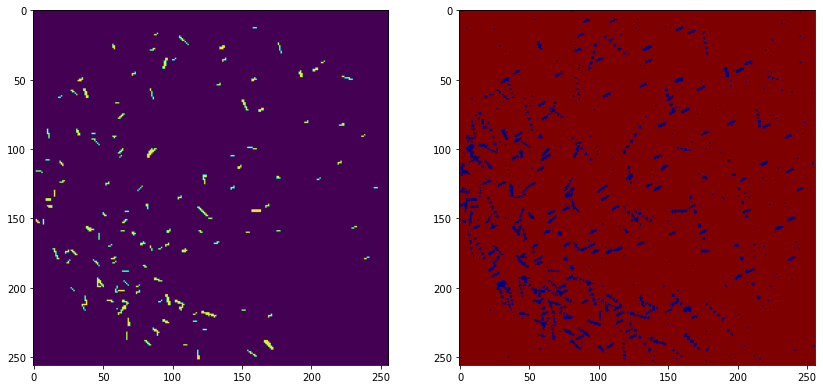

In [119]:
import cv2 as cv
Detected_Vectors=[]

distance_calibration_matrix=[0.3,0.3,0.3,0.3,0.3,0.3,0.3]

#higher difference= more lines detected
vector_diff_calibration_matrix=[4,4,4,4,4,8,9]

Draft2_pic5=np.zeros(np.shape(first_frame))
for m in range(1,np.max(cluster_data_count2)):
    
    if ((m!=1) | (m!=np.max(cluster_data_count2))):
        cluster_indx1=(np.transpose(cluster_data_count2[:])==m) | (np.transpose(cluster_data_count2[:])==(m-1) | (np.transpose(cluster_data_count2[:])==(m+1)))
        cluster_indx2=(np.transpose(cluster_data_count_second_frame2[:])==m) | (np.transpose(cluster_data_count_second_frame2[:])==(m-1) | (np.transpose(cluster_data_count_second_frame2[:])==(m+1)))
        cluster_indx3=(np.transpose(cluster_data_count_third_frame2[:])==m) | (np.transpose(cluster_data_count_third_frame2[:])==(m-1) | (np.transpose(cluster_data_count_third_frame2[:])==(m+1)))
        Group_of_1s=[xdata[cluster_indx1],ydata[cluster_indx1],np.array(cluster_data_av_mag_2)[cluster_indx1]]    
        Group_of_1s_second_frame=[xdata2[cluster_indx2],ydata2[cluster_indx2],np.array(cluster_data_av_mag_2_second_frame)[cluster_indx2]] 
        Group_of_1s_third_frame=[xdata3[cluster_indx3],ydata3[cluster_indx3],np.array(cluster_data_av_mag_2_third_frame)[cluster_indx3]]
    elif ((m==1)):
        cluster_indx1=((np.transpose(cluster_data_count2[:])==m) | (np.transpose(cluster_data_count2[:])==(m+1)))
        cluster_indx2=((np.transpose(cluster_data_count_second_frame2[:])==m) | (np.transpose(cluster_data_count_second_frame2[:])==(m+1)))
        cluster_indx3=((np.transpose(cluster_data_count_third_frame2[:])==m) |  (np.transpose(cluster_data_count_third_frame2[:])==(m+1)))
        Group_of_1s=[xdata[cluster_indx1],ydata[cluster_indx1],np.array(cluster_data_av_mag_2)[cluster_indx1]]    
        Group_of_1s_second_frame=[xdata2[cluster_indx2],ydata2[cluster_indx2],np.array(cluster_data_av_mag_2_second_frame)[cluster_indx2]] 
        Group_of_1s_third_frame=[xdata3[cluster_indx3],ydata3[cluster_indx3],np.array(cluster_data_av_mag_2_third_frame)[cluster_indx3]]
    elif(m==np.max(cluster_data_count2)):
        cluster_indx1=((np.transpose(cluster_data_count2[:])==m) | (np.transpose(cluster_data_count2[:])==(m-1) ))
        cluster_indx2=((np.transpose(cluster_data_count_second_frame2[:])==m) | (np.transpose(cluster_data_count_second_frame2[:])==(m-1)))
        cluster_indx3=((np.transpose(cluster_data_count_third_frame2[:])==m) | (np.transpose(cluster_data_count_third_frame2[:])==(m-1) ))  
        Group_of_1s=[xdata[cluster_indx1],ydata[cluster_indx1],np.array(cluster_data_av_mag_2)[cluster_indx1]]    
        Group_of_1s_second_frame=[xdata2[cluster_indx2],ydata2[cluster_indx2],np.array(cluster_data_av_mag_2_second_frame)[cluster_indx2]] 
        Group_of_1s_third_frame=[xdata3[cluster_indx3],ydata3[cluster_indx3],np.array(cluster_data_av_mag_2_third_frame)[cluster_indx3]]



    _1sframe=np.zeros(np.shape(first_frame))    
    reduced_xdata=Group_of_1s[0][:]
    reduced_ydata=Group_of_1s[1][:]
    reduced_bightness=Group_of_1s[2][:]
    for i in range(0,np.shape(reduced_xdata)[0]):
                _1sframe[reduced_xdata[i]][reduced_ydata[i]]=reduced_bightness[i]
    _1sframe2=np.zeros(np.shape(second_frame)) 
    reduced_xdata2=Group_of_1s_second_frame[0][:]
    reduced_ydata2=Group_of_1s_second_frame[1][:]
    reduced_bightness2=Group_of_1s_second_frame[2][:]
    for i in range(0,np.shape(reduced_xdata2)[0]):
                _1sframe2[reduced_xdata2[i]][reduced_ydata2[i]]=reduced_bightness2[i]
    _1sframe3=np.zeros(np.shape(third_frame)) 
    reduced_xdata3=Group_of_1s_third_frame[0][:]
    reduced_ydata3=Group_of_1s_third_frame[1][:]
    reduced_bightness3=Group_of_1s_third_frame[2][:]
    for i in range(0,np.shape(reduced_xdata3)[0]):
                _1sframe3[reduced_xdata3[i]][reduced_ydata3[i]]=reduced_bightness3[i]
    #possible frame 3 coordinates
    possible_frame3_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame3_coords=[]

    possible_frame2_coords=[]
    #frame1_x,frame1_y,[frame2_x,frame2_y]
    reduced_possible_frame2_coords=[]

    for i in range(0,np.shape(_1sframe)[0]):
        for j in range (0,np.shape(_1sframe)[1]):

            #If dot detected, perform search for second dot
            if _1sframe[i,j] != 0:
                #Perfrom "Search" based on average brightness
                possible_frame2_coords.append([i,j,np.where((_1sframe2>(_1sframe[i,j]-(_1sframe[i,j]*distance_calibration_matrix[m]))) & (_1sframe2<(_1sframe[i,j]+(_1sframe[i,j]*distance_calibration_matrix[m]))))])
    
    for i in range(0,np.shape(_1sframe2)[0]):
        for j in range(0,np.shape(_1sframe2)[1]):
            if _1sframe2[i,j] != 0:
                possible_frame3_coords.append([i,j,np.where((_1sframe3>(_1sframe2[i,j]-(_1sframe2[i,j]*distance_calibration_matrix[m]))) & (_1sframe3<(_1sframe2[i,j]+(_1sframe2[i,j]*distance_calibration_matrix[m]))))])
     
    
    #draw coords has frame1_x,frame1_y,frame2_x,frame2_y
    
    draw_coords=[]
    draw_coords2=[]
    #Filter with distance 
    for i in range(0,np.shape(possible_frame2_coords)[0]):
        for j in range(0,np.shape(possible_frame2_coords[i][2])[1]):
            x_diff=possible_frame2_coords[i][0]-(possible_frame2_coords[i][2])[0][j]
            y_diff=possible_frame2_coords[i][1]-(possible_frame2_coords[i][2])[1][j]
            if ((np.linalg.norm(x_diff)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff)<vector_diff_calibration_matrix[m])):
                draw_coords.append([possible_frame2_coords[i][0],possible_frame2_coords[i][1],(possible_frame2_coords[i][2])[0][j],(possible_frame2_coords[i][2])[1][j]])

    #draw_coords2 has frame2_x,frame2_y,frame3_x,frame3_y
    for k in range(0,np.shape(possible_frame3_coords)[0]):
        for l in range(0,np.shape(possible_frame3_coords[k][2])[1]):
            x_diff2=possible_frame3_coords[k][0]-(possible_frame3_coords[k][2])[0][l]
            y_diff2=possible_frame3_coords[k][1]-(possible_frame3_coords[k][2])[1][l]
            if ((np.linalg.norm(x_diff2)<vector_diff_calibration_matrix[m]) & (np.linalg.norm(y_diff2)<vector_diff_calibration_matrix[m])):
                draw_coords2.append([possible_frame3_coords[k][0],possible_frame3_coords[k][1],(possible_frame3_coords[k][2])[0][l],(possible_frame3_coords[k][2])[1][l]])
    
    #Connections Filtering
    #Creates new lines from previous lines Frame 1 to 2, frame 2 to 3
    #draw_coords_3 has frame1_x,frame1_y,frame3_x,frame3_y
    draw_coords3=[]
    array_draw_coords=np.array(draw_coords)
    array_draw_coords2=np.array(draw_coords2)
    if (np.shape(draw_coords)[0]>0) & (np.shape(draw_coords2)[0]>0):
        for i in range(0,np.shape(array_draw_coords)[0]):
            for j in range(0,np.shape(array_draw_coords2)[0]):
                #adding slope constraint
                slope1=np.linalg.norm((array_draw_coords[i,3]-array_draw_coords[i,1])/(array_draw_coords[i,2]-array_draw_coords[i,0]))
                slope2=np.linalg.norm((array_draw_coords2[j,3]-array_draw_coords2[j,1])/(array_draw_coords2[j,2]-array_draw_coords2[j,0]))
                slope_percent_bound=0.01
                if (slope1==slope2):
                #if ((slope1>(slope2-slope2*slope_percent_bound)) | (slope1<(slope2+slope2*slope_percent_bound)) ):
                    if (((array_draw_coords)[i,2]==array_draw_coords2[j,0]) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                        draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                    if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])+1) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                        draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                    if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])-1) & (array_draw_coords[i,3]==array_draw_coords2[j,1])) :
                        draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                    if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])) & (array_draw_coords[i,3]==array_draw_coords2[j,1]+1)) :
                        draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 
                    if ((array_draw_coords[i,2]==(array_draw_coords2[j,0])) & (array_draw_coords[i,3]==array_draw_coords2[j,1]-1)) :
                        draw_coords3.append([array_draw_coords[i,0],array_draw_coords[i,1],array_draw_coords2[j,2],array_draw_coords2[j,3]]) 

    Detected_Vectors.append(draw_coords3)   

    #Draw lines
    for i in range(0,np.shape(draw_coords3)[0]):
        cv.line(Draft2_pic5,(draw_coords3[i][3],draw_coords3[i][2]),(draw_coords3[i][1],draw_coords3[i][0]),(255,255,255),1)

    
    


fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic5)

fig.add_subplot(1,2,2)
plt.imshow(_5_frame_binary_Image)

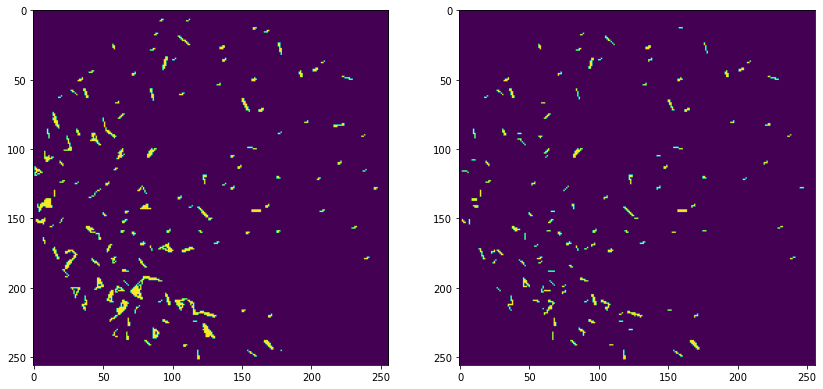

In [120]:
fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Draft2_pic4)

fig.add_subplot(1,2,2)
plt.imshow(Draft2_pic5)

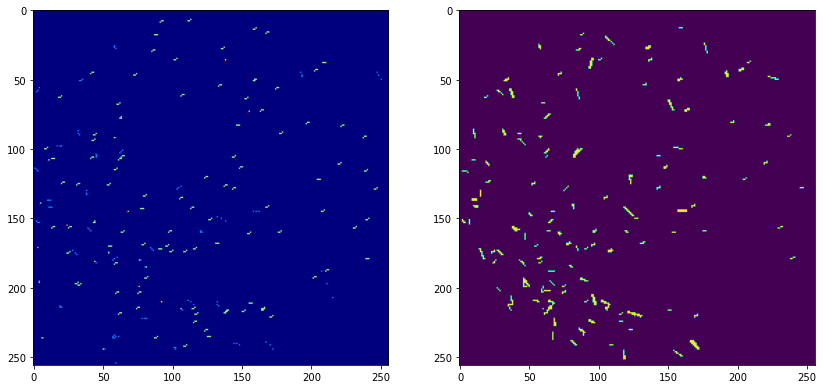

In [121]:
fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(image5)

fig.add_subplot(1,2,2)
plt.imshow(Draft2_pic5)

This method gives us a decent identification of the paths traveled by the chosen object. This is done through comparing the number of pixels in a cluster and the average brightness of the given cluster on two different frames. A line is formed between these two frames. A third frame is introduced and connections are made between the second frame and the third frame. These results are filtered by only allowing a continuos line to pass through, that is the end point of the line connecting frame 1 and frame 2 is the starting point from frame 2 to frame 3. Another filter is added so that the line from frame 1 to frame 2 must have the same slope as the line created from the second frame to the third frame. 

# Classicifcation

Now that we have vectors for each detected streak. We can corelate the given vector with clusters in the first 3 frames

## Repacking Detected_Vectors

In [122]:
from statistics import mode
#Detected_Vectors2
Detected_Vectors2=[]
for i in range(0,np.shape(Detected_Vectors)[0]):
    for k in range(0,np.shape(Detected_Vectors[i])[0]):
        Detected_Vectors2.append(Detected_Vectors[i][k])

Detected_Vectors2=np.array(Detected_Vectors2)        



# Classifying as Stars

In [143]:
from statistics import mode
mode(Detected_Lengths)


2.23606797749979

From our previous work we know that Stars typically have a slope of around -0.5. This is the mode of the slopes calculated.

<ipython-input-146-f0741f91ab00>:1: RuntimeWarning: divide by zero encountered in true_divide
  Detected_Slopes=(Detected_Vectors2[:,2]-Detected_Vectors2[:,0])/(Detected_Vectors2[:,3]-Detected_Vectors2[:,1])
<ipython-input-146-f0741f91ab00>:1: RuntimeWarning: invalid value encountered in true_divide
  Detected_Slopes=(Detected_Vectors2[:,2]-Detected_Vectors2[:,0])/(Detected_Vectors2[:,3]-Detected_Vectors2[:,1])


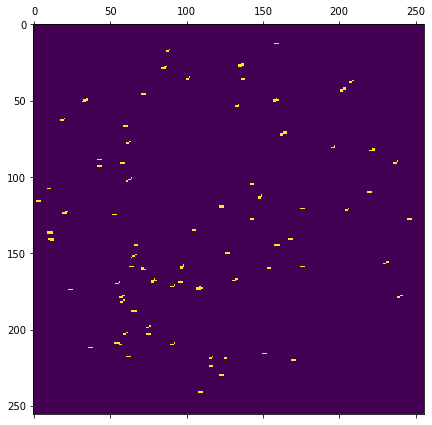

In [146]:
Detected_Slopes=(Detected_Vectors2[:,2]-Detected_Vectors2[:,0])/(Detected_Vectors2[:,3]-Detected_Vectors2[:,1])
Detected_Lengths=[]
for i in range(0,np.shape(Detected_Slopes)[0]):
    Detected_Lengths.append(np.linalg.norm([(Detected_Vectors2[i,2]-Detected_Vectors2[i,0]),(Detected_Vectors2[i,3]-Detected_Vectors2[i,1])]))

Star_slopes_image=np.zeros(np.shape(first_frame))
Star_slopes=Detected_Vectors2[((Detected_Slopes>-0.7) & (Detected_Slopes<0.1) & (np.transpose(Detected_Lengths)<4)) ]
for i in range(0,np.shape(Star_slopes)[0]):
        cv.line(Star_slopes_image,(Star_slopes[i][1],Star_slopes[i][0]),(Star_slopes[i][3],Star_slopes[i][2]),(1,1,1),1)
plt.matshow(Star_slopes_image)

Now that we have the 2D map of the RSOs, we need to correlate it to the clusters discovered in frame 1,2 and 3

In [124]:
#We may also have an issue with overlap--- that is if there is a point on our star_slope_image "map" that is lit but does not correlate to a RSO 

truth_data1=np.zeros(np.shape(cluster_data)[1])
#frames 1
#in cluster form

truth_data2=np.zeros(np.shape(cluster_data2)[1])
#frame 2 in cluster form

truth_data3=np.zeros(np.shape(cluster_data2)[1])

for i in range(0,np.shape(Star_slopes_image)[0]):
    for j in range(0,np.shape(Star_slopes_image)[1]):
        if Star_slopes_image[i][j]==1:
            truth_data1[np.where((cluster_data[0]==i)&(cluster_data[1]==j))]=2
            truth_data2[np.where((cluster_data2[0]==i)&(cluster_data2[1]==j))]=2
            truth_data3[np.where((cluster_data3[0]==i)&(cluster_data3[1]==j))]=2
            


From running diagnosis to check out truth data, we see that some points on the cluster are not included with the detection

# Classifying RSOs

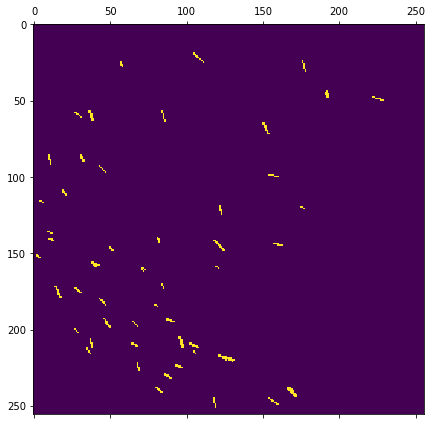

In [125]:
RSO_slopes_image=np.zeros(np.shape(first_frame))
RSOs=Detected_Vectors2[((np.isinf(Detected_Slopes)==0)&(np.sign(Detected_Slopes)==1))]
for i in range(0,np.shape(RSOs)[0]):
        cv.line(RSO_slopes_image,(RSOs[i][1],RSOs[i][0]),(RSOs[i][3],RSOs[i][2]),(1,1,1),1)
plt.matshow(RSO_slopes_image)

In [126]:
for i in range(0,np.shape(RSO_slopes_image)[0]):
    for j in range(0,np.shape(RSO_slopes_image)[1]):
        if RSO_slopes_image[i][j]==1:
            truth_data1[np.where((cluster_data[0]==i)&(cluster_data[1]==j))]=1
            truth_data2[np.where((cluster_data2[0]==i)&(cluster_data2[1]==j))]=1
            truth_data3[np.where((cluster_data3[0]==i)&(cluster_data3[1]==j))]=1

# Comparison to Truth Data

In [127]:
np.shape(RSO_label_data)

(256, 256)

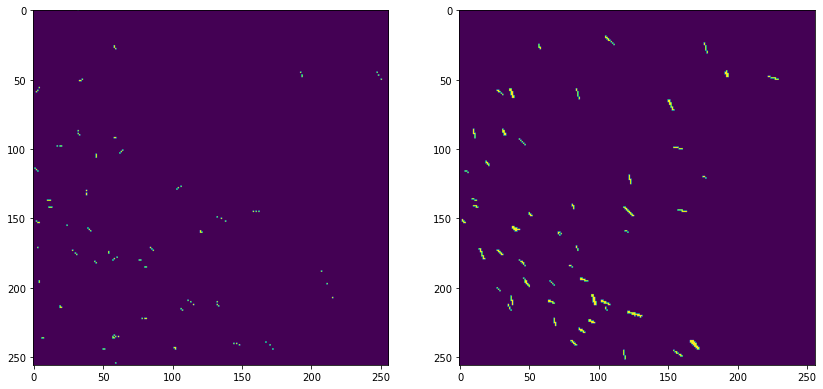

In [128]:
#RSO Comparison
RSO_label_data=np.zeros(np.shape(first_frame))
for i in range(0,np.shape(RSO_label_data)[0]):
    for j in range(0,np.shape(RSO_label_data)[1]):
        for k in range(0,3,1):
            if ((label_data[k][i][j]==1)):
                RSO_label_data[i][j]=1
        
    

#cmap=plt.cm.jet #Adds Color Map
#norm2=plt.Normalize(vmin=RSO_label_data.min(),vmax=RSO_label_data.max()) #Normalizes Data
#image6=cmap(RSO_label_data)
#plt.imsave('ahh.png',image6)

#plt.imshow(image5)


#RSO_label_data=np.zeros(np.shape(image5))
#RSO_label_data[np.where(image5==1)]=1
fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(RSO_label_data)

fig.add_subplot(1,2,2)
plt.imshow(RSO_slopes_image)

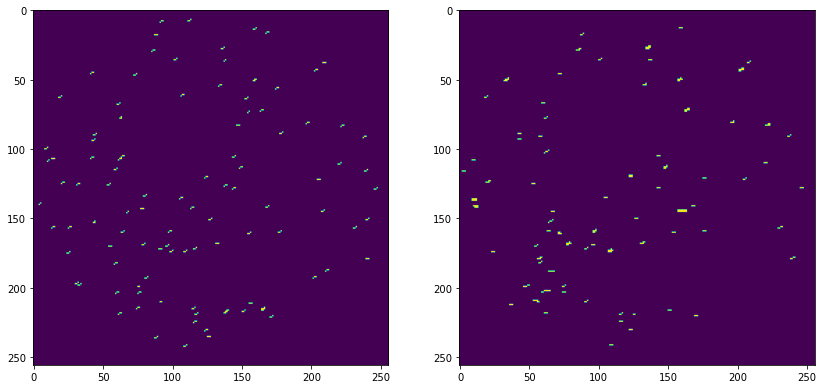

In [129]:
#star Comparison 
Star_label_data=np.zeros(np.shape(first_frame))
for i in range(0,np.shape(Star_label_data)[0]):
    for j in range(0,np.shape(Star_label_data)[1]):
        for k in range(0,3,1):
            if ((label_data[k][i][j]==2)):
                Star_label_data[i][j]=1
        
    

#cmap=plt.cm.jet #Adds Color Map
#norm2=plt.Normalize(vmin=RSO_label_data.min(),vmax=RSO_label_data.max()) #Normalizes Data
#image6=cmap(RSO_label_data)
#plt.imsave('ahh.png',image6)

#plt.imshow(image5)


#RSO_label_data=np.zeros(np.shape(image5))
#RSO_label_data[np.where(image5==1)]=1
fig=plt.figure(figsize=plt.figaspect(0.5))
fig.add_subplot(1,2,1)
plt.imshow(Star_label_data)

fig.add_subplot(1,2,2)
plt.imshow(Star_slopes_image)

# Conclusion

Known Issues:
- Classification through Slope and Length isn't also accurate. This is because RSOs can have the same slope as Stars and be falsely labeled as RSOs
    - It is recommended to add a brigtness filter to this program to better classify RSOs
- Cluster Sizes. Calibration Arrays are inputted manually to ensure that RSOs/Stars are properly identified 

# Table Creation

The purpose of the table creation is to replicate the paramters used for Option 2 of this assignment. That is, put the X and Y centroid, brightness, X direction and Y direction into a table. The last column is that of the truth table- whether the cluster of lit pixels are an RSO, Star or Other

NameError: name 'RSO_binary_5frame_image' is not defined